# Health insurance cross sell prediction with XGBoost

## 1. Problem description

[This dataset](https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction) contains a list of health insurance customers. The "Response" column indicates whether the customer also wanted to use car insurance.

I'll try to build an effective model that predicts this decision using XGBoost, Optuna hyperparameters tuning, feature encoding, feature selection and few other tricks. First I'll do some classic (non-ML) data analysis and later I'll try to go a little deeper into how the model works.

In [1]:
from common import *
import warnings
warnings.filterwarnings("ignore")


print("Number of rows:", df.shape[0])
df.head()

Number of rows: 381109


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 2. Initial data visualization, columns explanation, EDA

I'll do some simple data analysis without Machine Learning models - using various types of plots and elementary mathematical operations.

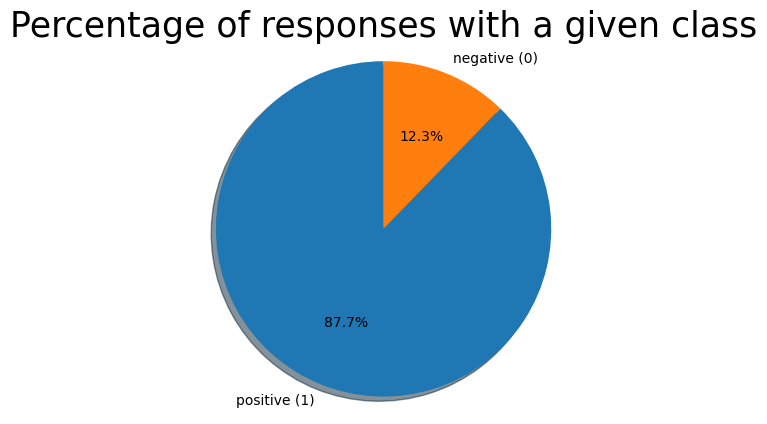

In [2]:
labels = ["positive (1)", "negative (0)"]
negative = df[df.Response == 0].size
positive = df[df.Response == 1].size
sizes = [negative, positive]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Percentage of responses with a given class", fontsize=25)
plt.show()

People who choose both insurances highly outnumber those who do not (87,7%). It's an important information - it's type of "imbalanced dataset". I need to use specific tools for it.

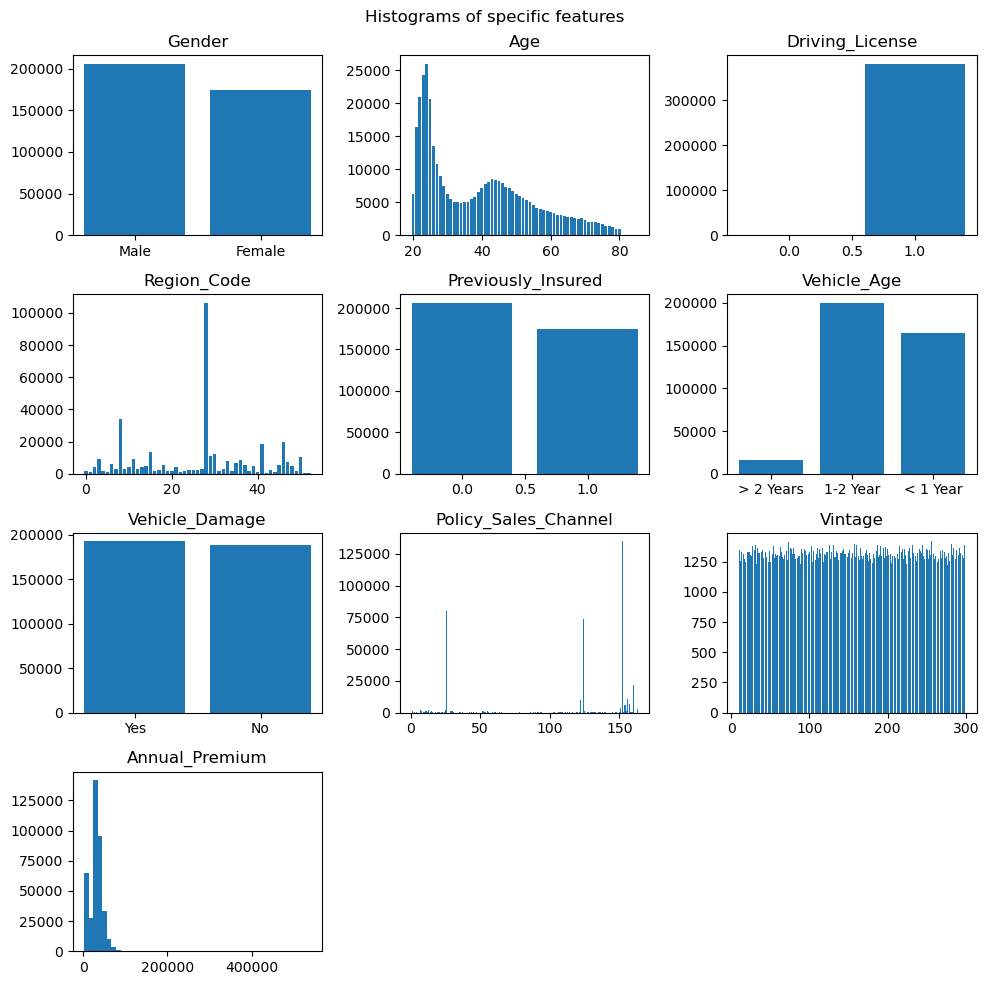

In [5]:
def add_bar_plot(ax, X, column):
    counts = X[column].value_counts(sort=False)
    names = counts.index.values.tolist()
    values = counts.values.tolist()
    ax.bar(names, values)
    ax.set_title(column)

fig, ax = plt.subplots(4, 3, figsize=(10, 10))
cat_features = X.drop(columns='Annual_Premium').columns.values.tolist()
for idx, column in enumerate(cat_features):
    add_bar_plot(ax[idx // 3, idx % 3], X, column)

ax[3,0].hist(X['Annual_Premium'], bins=50)
ax[3,0].set_title('Annual_Premium')

ax[3,1].axis('off')
ax[3,2].axis('off')
fig.suptitle('Histograms of specific features')
fig.tight_layout()

1. ***Gender*** - there are slightly more males than females.
2. ***Age*** - the majority of people are between the ages of 20 and 30. There is also a second, smaller peak around the age of 45.
3. ***Driving_License*** - the vast majority of customers have a driver's license.
4. ***Region_Code*** - some regions have many more customers than others.
5. ***Previously_Insured*** - this column indicates whether or not a customer has insurance (0 = no, 1 = yes). 54% don't have one.
6. ***Vehicle_Age*** - most people have young cars (less than 1 year old), slightly fewer in the 1-2 year range, and noticeably fewer over 2 years old.
7. ***Vehicle_Damage*** - a similar proportion of customers have a car with and without damage.
8. ***Policy_Sales_Channel*** - there is no detailed description of the specific values of this column. Some sales channels are orders of magnitude more likely to be used than others.
9. ***Vintage*** - "number of days, customer has been associated with the company. The column has very even distribution - the company most likely received a similar number of customers throughout the year.
10. ***Annual_Premium*** - this feature describes "the amount customer needs to pay as premium in the year". The column resembles most data with salaries - it has a long "right tail".

### 2.1 Mutual information
Mutual information is a tool for measuring the dependence between two variables. It uses the "K nearest neighbors" algorithm to describe it. If you want to expand your knowledge, look at the sklearn MI [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html)

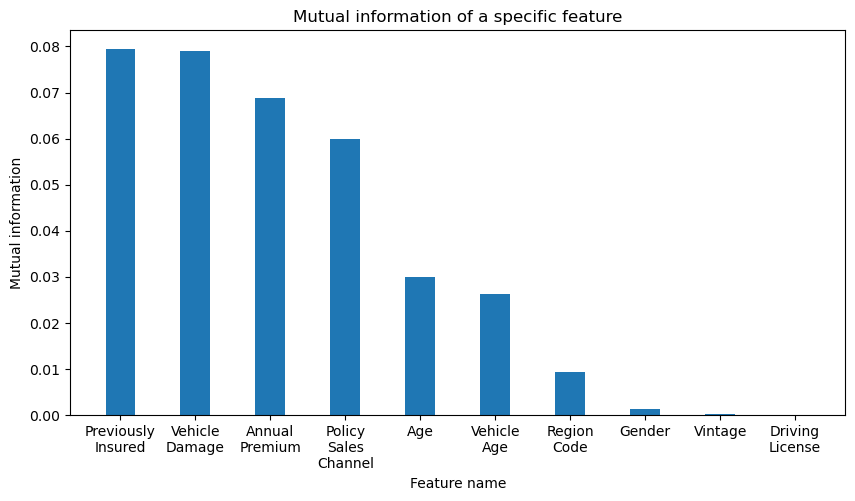

In [2]:
mi = mutual_info_classif(X_le, y, random_state=42, discrete_features=[0, 1, 2, 3, 4, 5, 6, 7, 9])

data = pd.Series(mi, name="MI Scores", index=X_le.columns).sort_values(ascending=False)

def underscore_to_space(text):
    return text.replace("_", "\n")

region_code = list(  map(underscore_to_space, data.index.tolist())   )
customers = list(data.values.tolist())

fig = plt.figure(figsize = (10, 5))
plt.bar(region_code, customers,
        width = 0.4)
 
plt.xlabel("Feature name")
plt.ylabel("Mutual information")
plt.title("Mutual information of a specific feature")
plt.show()

### 2.2 KDE plots

KDE plots visualize the distribution of observations (similar to histograms). In each graph, I'll show a separate distribution of the two classes. It will allow us to compare them.

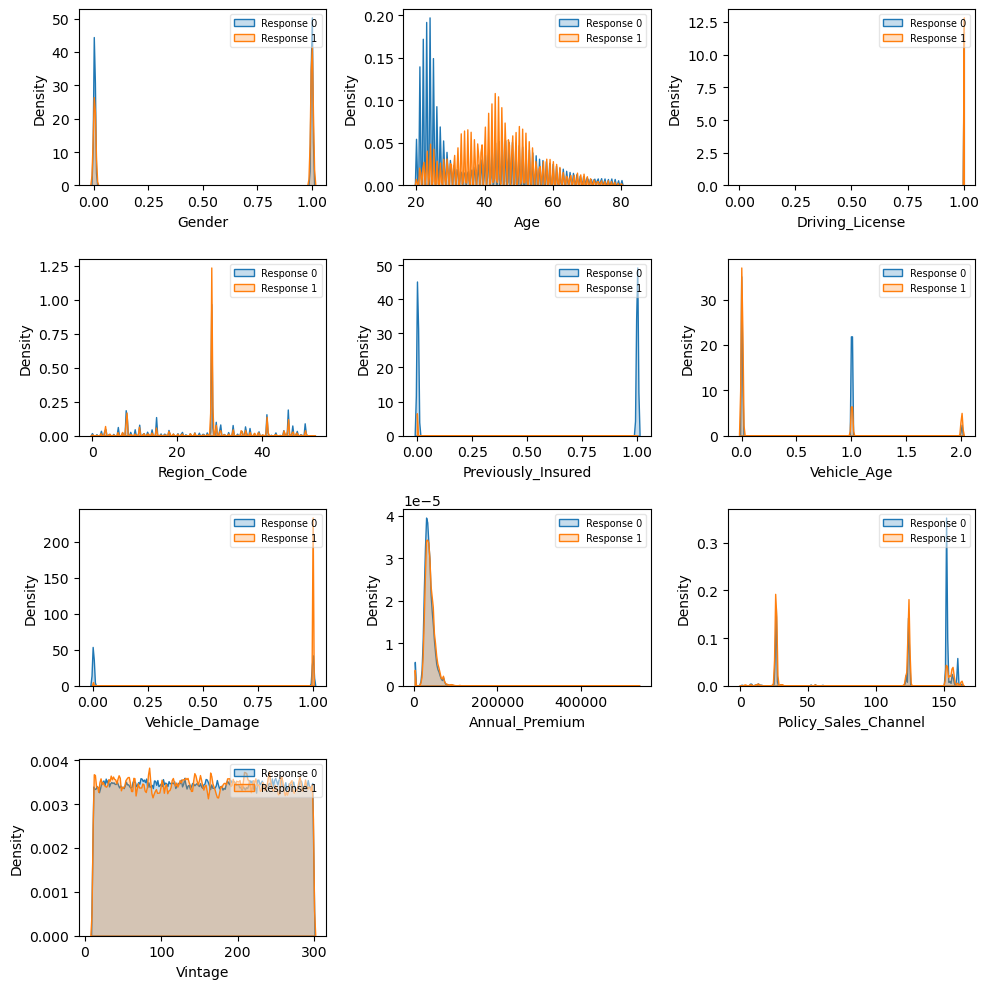

In [5]:
dfresponse0 = df_le[df_le["Response"] == 0]
dfresponse1 = df_le[df_le["Response"] == 1]

cols = df_le.drop(columns='Response').columns

height = 4
width = math.ceil(len(cols) / height)

fig, ax = plt.subplots(height, width, figsize=(10, 10))
index = 0
for columnX in cols:
    sns.kdeplot(data=dfresponse0[columnX], label="Response 0", shade=True, ax=ax[index//width][index % width], bw_adjust=0.1)
    sns.kdeplot(data=dfresponse1[columnX], label="Response 1", shade=True, ax=ax[index//width][index % width], bw_adjust=0.1)
    ax[index//width][index % width].legend(loc='best', prop={'size': 7}, fancybox=True, framealpha=0.5)
    index += 1

while index < height * width:
    ax[index//width][index % width].axis('off')
    index+=1

fig.tight_layout()
plt.show()

1. Gender - at first glance, we can see that a higher percentage of men (label 1) opt for car insurance. The relationship is noticeable, but not very strong.
2. Age - young people are usually not interested in the service, the most frequent users are those aged 40-50. Among people of a particular age the relationship is quite strong - the percentage can vary as much as 3-4 times. In some ranges, however, the difference is not large - for example, around the age of 30.
3. Region_Code - people in certain regions have a much higher or lower percentage of service users, but it is also important to keep in mind how regions vary in the total number of customers.
4. Previously_Insured - people with insurance usually do not want to buy a new one, contrary to people without insurance. The relationship is very strong.
5. Vehicle_Age (0 - '1-2 Year', 1 - '< 1 Year', 2 - '> 2 Years') - people prefer to insure old cars over new ones.
6. Vehicle_Damage 0 - 'no', 1 - 'yes' - we can see that damaged cars have a much higher percentage of insurance.
7. Annual_Premium - it's difficult to determine from the raw data, it is better to present a second graph with the logarithm of the feature.
8. Policy_Sales_Channel - insurance percentages can vary widely for specific sales channels.
9. Vintage - this feature is unlikely to affect the outcome.

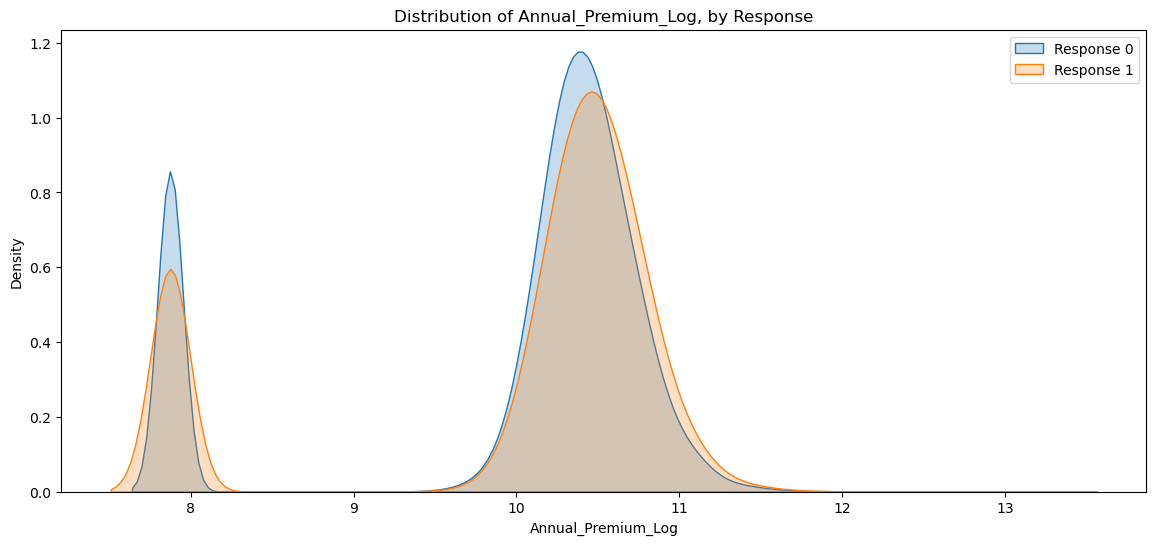

In [6]:
df_log = df_le[['Annual_Premium', 'Response']].copy()
df_log['Annual_Premium_Log'] = np.log(df['Annual_Premium'])

dfresponse0 = df_log[df_log["Response"] == 0]
dfresponse1 = df_log[df_log["Response"] == 1]

plt.figure(figsize=(14, 6))
sns.kdeplot(data=dfresponse0['Annual_Premium_Log'], label="Response 0", shade=True)
sns.kdeplot(data=dfresponse1['Annual_Premium_Log'], label="Response 1", shade=True)

plt.title("Distribution of Annual_Premium_Log, by Response")
plt.legend()
plt.show()

# TODO: is this graph to big?

Here we can see, that Annual_Premium affects output. It's not so easy to describe, but model probably will be able to use this information properly.

### 2.3 initial analysis summary
Previously_Insured and Vehicle_Damage are very important features - both techniques (KDE plots and mutual information) confirm that. It is necessary to encode Region_Code and Policy_Sales_Channel before drawing deeper conclusions.

## 3. Basic model with logistic regression
First, I'll build a quite simple model. It will enable me to check if my next steps improve the result. Logistic regression is one of the least complex algorithms, so it'll be my initial try.

### 3.1 Metric
This problem is an example of an "imbalanced dataset". It means that one class ("negative" or "zero" in this article) has significantly more samples than the others. You can get 87.7% accuracy... just by assigning the same prediction to all cases! There are more reliable metrics for imbalanced datasets - one of them is ROC AUC.

#### 3.1.1 True positive rate, False positive rate
For a proper understanding of the ROC AUC metric, it is necessary first to explain TPR (true positive rate) and FPR (false positive rate).

The "true positive rate" is the number of properly predicted positive cases divided by all positive cases. For example, if there are 10.000 customers who chose insurance and our model found 9.500 of them - TPR equals 9.500/10.000 = 95%.

The "false positive rate" is the number of falsely predicted positive cases divided by all negative cases. For example, if there are 100.000 customers who didn't choose insurance and our model predicted that 1.000 of them would choose it, the FPR equals 1.000/100.000 = 1%.

#### 3.1.2 Receiver operating characteristic
Usually we can set a threshold describing how sure the algorithm needs to be to predict the result for a single sample as "true". There is TPR on the vertical axis and FPR on the horizontal axis, and the ROC curve is created by plotting points for consecutive thresholds.

#### 3.1.3 ROC Area under curve
It could be hard to simply compare various ROC curves. For this purpose, I'll use the final metric, the ROC AUC (area under the curve). The algorithm will calculate the area under the ROC curve - it's much easier to compare single numbers.


### 3.2 Cross validation
Cross validation is a way of measuring model performance. It divides all the data into a given number of parts. Later in each iteration, one part is used as validation data and the rest as training data. Each part was used as test data after all iterations. This method gives more reliable measurements than standard one-step validation.

In [3]:
logreg = LogisticRegression(random_state=42, n_jobs=-1)
logreg_score = cross_val_summary(logreg, X_le, y)

Cross validation time: 10.679848670959473 seconds
Mean score: 0.6472343703624961


## 4. Simple model with Light GBM
LightGBM is much more complex algorithm originally created by Microsoft. Explaining of the main idea is too long for this article, but in general it's tree-based model. I encourage you to ckeck [this article](https://towardsdatascience.com/what-makes-lightgbm-lightning-fast-a27cf0d9785e).

In [3]:
lgbm = LGBMClassifier(random_state=42, verbose=-1)
basic_lgbm_score = cross_val_summary(lgbm, X_le, y)

Cross validation time: 3.745525598526001 seconds
Mean score: 0.8575017665775645


The result is ***much*** higher with a lower execution time. Now I'll try to improve a little the performance of this algorithm - first by modifying the input data.

## 5 Remove 'Vintage' column

As I said in one of the previous steps, it looks like the feature "Vintage" really cannot add any relevant information to the model. Let's check the result after dropping this column:

In [5]:
drop_vintage_score = cross_val_summary(lgbm, X_le.drop(columns="Vintage"), y, message="Mean ROC_AUC without 'Vintage' column: ")

Cross validation time: 3.5287601947784424 seconds
Mean ROC_AUC without 'Vintage' column: 0.8577693288099889


ROC_AUC is slightly higher and calculations are faster. From now on, I won't use this feature in any model.

I tried to extract more specific information from 'Vintage' feature, such as day of the week, month etc., but it didn't help one bit.

## 6. StandardScaler vs PowerTransformer vs QuantileTransformer

Tree-based algorithms handle non-scaled data quite well, but we can still check how various scaling and transforming methods affect the model.

In [9]:
def compare_preprocessing(model, X, y):
    scaler = StandardScaler()
    transformer = PowerTransformer()
    scaler_without_std = StandardScaler(with_std=False)
    quant_trans_uniform = QuantileTransformer(output_distribution='uniform')
    quant_trans_normal = QuantileTransformer(output_distribution='normal')

    model_scaler = make_pipeline(scaler, model)
    model_transformer = make_pipeline(transformer, model)
    model_scaler_transformer = make_pipeline(scaler_without_std, transformer, model)
    model_quant_trans_uniform = make_pipeline(quant_trans_uniform, model)
    model_quant_trans_normal = make_pipeline(quant_trans_normal, model)
    highest_score = cross_val_summary(model, X, y, message="Mean ROC_AUC score without scaler: ")
    highest_score = max(highest_score, cross_val_summary(model_scaler, X, y, message="Mean ROC_AUC score with scaler: "))
    highest_score = max(highest_score, cross_val_summary(model_transformer, X, y, message="Mean ROC_AUC score with transformer: "))
    highest_score = max(highest_score, cross_val_summary(model_scaler_transformer, X, y, message="Mean ROC_AUC score with scaler and transformer: "))
    highest_score = max(highest_score, cross_val_summary(model_quant_trans_uniform, X, y, message="Mean ROC_AUC score with QuantileTransformer (uniform distribution): "))
    highest_score = max(highest_score, cross_val_summary(model_quant_trans_normal, X, y, message="Mean ROC_AUC score with QuantileTransformer (normal distribution): "))
    return highest_score

compare_preprocessing(lgbm, X_le.drop(columns="Vintage"), y)

Cross validation time: 3.5629632472991943 seconds
Mean ROC_AUC score without scaler: 0.8577693288099889
Cross validation time: 3.523454189300537 seconds
Mean ROC_AUC score with scaler: 0.8574143509437648
Cross validation time: 18.843132495880127 seconds
Mean ROC_AUC score with transformer: 0.8577319376846066
Cross validation time: 22.311618089675903 seconds
Mean ROC_AUC score with scaler and transformer: 0.8577400779770201
Cross validation time: 5.493622541427612 seconds
Mean ROC_AUC score with QuantileTransformer (uniform distribution): 0.8576643396361232
Cross validation time: 6.019064664840698 seconds
Mean ROC_AUC score with QuantileTransformer (normal distribution): 0.8576946723866874


0.8577693288099889

The differences between various scaling methods are small, so I need to make more tests after the next steps. For now... version without scaler obtains highest score, but it will change later.

## 7. Policy_Sales_Channel One Hot Encoding

"Policy_Sales_Channel" is a categorical column. Algorithms cannot always effectively use this type of data in a single column. For example, channel 2 is not "smaller" than channel 4, and channel 3 is not "between" them in a mathematical sense. There are some tools for addressing this problem. For now, I'll use One Hot Encoding. It creates a new column for each of the categories and fills it with 1 if the sample falls into that category and with 0 if it does not.

In [11]:
psc_ohe = pd.get_dummies(X_le["Policy_Sales_Channel"], prefix="Policy_Sales_Channel")
X_le_psc = pd.concat([X_le, psc_ohe], axis=1)
psc_ohe_score = compare_preprocessing(lgbm, X_le_psc.drop(columns="Vintage"), y)
print("Highest score: ", str(psc_ohe_score))

Cross validation time: 6.825916051864624 seconds
Mean ROC_AUC score without scaler: 0.8574873160321502
Cross validation time: 16.860718488693237 seconds
Mean ROC_AUC score with scaler: 0.8577947969646201
Cross validation time: 288.846892118454 seconds
Mean ROC_AUC score with transformer: 0.8577408859764913
Cross validation time: 405.9879322052002 seconds
Mean ROC_AUC score with scaler and transformer: 0.8575996426275662
Cross validation time: 22.277268648147583 seconds
Mean ROC_AUC score with QuantileTransformer (uniform distribution): 0.8576919569781671
Cross validation time: 33.62780690193176 seconds
Mean ROC_AUC score with QuantileTransformer (normal distribution): 0.8575725156885111
Highest score:  0.8577947969646201


Some of the results are higher, while some are worse. Training time has increased significantly. I tested it, and the performance with the original Policy_Sales_Channel column removed is even worse.

So... Why the algorithm can't effectively use new features?
Unfortunately, there are 155 distinct categories. Given the nearly 400.000 samples and complex algorithm, this step significantly slows down training. Furthermore, it generates a large number of columns with a few "ones" and several hundred thousand "zeroes". Such columns provide a lot of noise but little meaningful information.

How can we curb this problem?

If a given policy sales channel occurs only once in the whole dataset, it can't be used to predict other samples. At first, I will eliminate such categories.

In [6]:
psc_ohe = pd.get_dummies(X_le["Policy_Sales_Channel"], prefix="Policy_Sales_Channel")

counts = X_le["Policy_Sales_Channel"].value_counts()
counts = counts[counts == 1]
columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(x), counts.index.tolist()))
psc_ohe = psc_ohe.drop(columns=columns_to_remove)

X_le_psc = pd.concat([X_le, psc_ohe], axis=1)
compare_preprocessing(lgbm, X_le_psc.drop(columns="Vintage"), y)

Cross validation time: 6.6485631465911865 seconds
Mean ROC_AUC score without scaler: 0.8574873160321502
Cross validation time: 15.803345680236816 seconds
Mean ROC_AUC score with scaler: 0.8577947969646201
Cross validation time: 279.7007312774658 seconds
Mean ROC_AUC score with transformer: 0.8577408859764913
Cross validation time: 388.281920671463 seconds
Mean ROC_AUC score with scaler and transformer: 0.8575996426275662
Cross validation time: 25.3707914352417 seconds
Mean ROC_AUC score with QuantileTransformer (uniform distribution): 0.8576919569781671
Cross validation time: 34.4904682636261 seconds
Mean ROC_AUC score with QuantileTransformer (normal distribution): 0.8577321633308663


For most scalers and transformers, the results are the same but achieved faster. Maybe it's possible to drop more features without decreasing the performance? I'll measure it by dropping consecutive Policy_Sales_Channel OHE columns with the smallest number of "ones". I'll use the QuantileTransformer model version (uniform output distribution).

Done iterations: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,

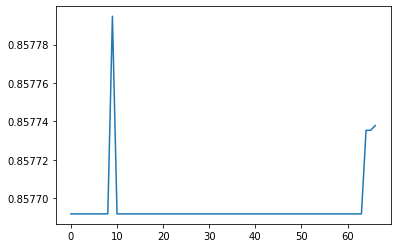

In [64]:
value_counts = X_le_psc["Policy_Sales_Channel"].value_counts().index
quant_trans_uniform = QuantileTransformer(output_distribution='uniform')
model = make_pipeline(quant_trans_uniform, lgbm)
scores = []

iteration = 0
print('Done iterations: ', end='')
for x in range(147, 1, -1):
    iteration += 1
    columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(value_counts[x]), [*range(147, x-1, -1)]))
    columns_to_remove += ['Vintage']
    score = cross_val_score(model, X_le_psc.drop(columns=columns_to_remove), y, cv=10, scoring='roc_auc').mean()
    scores += [score]
    print(str(iteration) + ",", end='')

scores_series = pd.Series(scores)
plt.plot(scores_series.index, scores_series.values)

There is a single peak near 10, but unfortunately it's a very random improvement and it doesn't influence models with various parameters.

I'm sure I can remove 60 columns without affecting model performance, but I still need to look at the results for other scalers.

In [4]:
value_counts = X_le_psc["Policy_Sales_Channel"].value_counts().index
columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(value_counts[x]), [*range(147, 86, -1)]))
columns_to_remove += ['Vintage']

compare_preprocessing(lgbm, X_le_psc.drop(columns=columns_to_remove), y)

Cross validation time: 5.6952736377716064 seconds
Mean ROC_AUC score without scaler: 0.8574873160321502
Cross validation time: 12.071979999542236 seconds
Mean ROC_AUC score with scaler: 0.8577947969646201
Cross validation time: 162.0033049583435 seconds
Mean ROC_AUC score with transformer: 0.8577408859764913
Cross validation time: 218.17398762702942 seconds
Mean ROC_AUC score with scaler and transformer: 0.8575996426275662
Cross validation time: 15.900956869125366 seconds
Mean ROC_AUC score with QuantileTransformer (uniform distribution): 0.8576919569781671
Cross validation time: 24.017045259475708 seconds
Mean ROC_AUC score with QuantileTransformer (normal distribution): 0.8578170529189757


The results are the same (even better for QuantileTransformer with normal distribution), but training is much faster (almost a 2-fold improvement for the model version with the transformer!). I'll do more precise feature selection after two more econdings (the results will be more accurate).

## 8 Target encoding on Policy_Sales_Channel

The second type of category encoding is supervised encoding. It uses target values to encode category. In practice, the algorithm is a bit more complex, but the main idea is to substitute categorical values by their mean target (the "Response" column). Let's encode Policy_Sales_Channel in this way and compare results for various scalers:

In [17]:
def compare_preprocessing_te(model, X, y, te_columns):
    encoder = TargetEncoder(cols=te_columns)

    scaler = StandardScaler()
    transformer = PowerTransformer()
    scaler_without_std = StandardScaler(with_std=False)
    quant_trans_uniform = QuantileTransformer(output_distribution='uniform')
    quant_trans_normal = QuantileTransformer(output_distribution='normal')

    model_te = make_pipeline(encoder, model)
    model_scaler = make_pipeline(encoder, scaler, model)
    model_transformer = make_pipeline(encoder, transformer, model)
    model_scaler_transformer = make_pipeline(encoder, scaler_without_std, transformer, model)
    model_quant_trans_uniform = make_pipeline(encoder, quant_trans_uniform, model)
    model_quant_trans_normal = make_pipeline(encoder, quant_trans_normal, model)

    highest_score = cross_val_summary(model_te, X, y, message="Mean ROC_AUC score without scaler: ")
    highest_score = max(highest_score, cross_val_summary(model_scaler, X, y, message="Mean ROC_AUC score with scaler: "))
    highest_score = max(highest_score, cross_val_summary(model_transformer, X, y, message="Mean ROC_AUC score with transformer: "))
    highest_score = max(highest_score, cross_val_summary(model_scaler_transformer, X, y, message="Mean ROC_AUC score with scaler and transformer: "))
    highest_score = max(highest_score, cross_val_summary(model_quant_trans_uniform, X, y, message="Mean ROC_AUC score with QuantileTransformer (uniform distribution): "))
    highest_score = max(highest_score, cross_val_summary(model_quant_trans_normal, X, y, message="Mean ROC_AUC score with QuantileTransformer (normal distribution): "))
    return highest_score

In [18]:
X_le_psc_te = X_le_psc.drop(columns=columns_to_remove).copy()
X_le_psc_te['Policy_Sales_Channel_te'] = X_le_psc_te['Policy_Sales_Channel']
psc_te_score = compare_preprocessing_te(lgbm, X_le_psc_te, y, ['Policy_Sales_Channel'])
print("Highest score: ", str(psc_te_score))

Cross validation time: 7.704759120941162 seconds
Mean ROC_AUC score without scaler: 0.8578516811768312
Cross validation time: 12.906744718551636 seconds
Mean ROC_AUC score with scaler: 0.8578067917946631
Cross validation time: 171.59169220924377 seconds
Mean ROC_AUC score with transformer: 0.8577500725688326
Cross validation time: 237.76457166671753 seconds
Mean ROC_AUC score with scaler and transformer: 0.857805818285436
Cross validation time: 17.466618537902832 seconds
Mean ROC_AUC score with QuantileTransformer (uniform distribution): 0.8577677650820392
Cross validation time: 24.417635440826416 seconds
Mean ROC_AUC score with QuantileTransformer (normal distribution): 0.8577674052135242
Highest score:  0.8578516811768312


Except for the QuantileTransformer with a normal distribution, all results are better. 

I checked, and the results without the original Policy_Sales_Channel column are worse.

## 9. TargetEncoding on Region_Code

Now I'll use the same method for Region_Code - with and without the non-encoded version.

First - without the original Region_Code column:

TODO: recalculate these scores

In [5]:
compare_preprocessing_te(lgbm, X_le_psc_te, y, ['Policy_Sales_Channel', 'Region_Code'])

Cross validation time: 7.385013580322266 seconds
Mean ROC_AUC score without scaler: 0.8578672559914619
Cross validation time: 12.798346519470215 seconds
Mean ROC_AUC score with scaler: 0.8580431893748506
Cross validation time: 163.73356127738953 seconds
Mean ROC_AUC score with transformer: 0.8580417526017181
Cross validation time: 218.94549584388733 seconds
Mean ROC_AUC score with scaler and transformer: 0.8580898524585432
Cross validation time: 17.591765880584717 seconds
Mean ROC_AUC score with QuantileTransformer (uniform distribution): 0.858124605199893
Cross validation time: 24.033880710601807 seconds
Mean ROC_AUC score with QuantileTransformer (normal distribution): 0.8579435208664062


With the original Region_Code column:

In [19]:
X_le_psc_te_rc = X_le_psc_te.copy()
X_le_psc_te_rc['Region_Code_te'] = X_le_psc_te_rc['Region_Code']

rc_te_score = compare_preprocessing_te(lgbm, X_le_psc_te_rc, y, ['Policy_Sales_Channel', 'Region_Code'])
print("Highest score: " + str(rc_te_score))

Cross validation time: 7.682689428329468 seconds
Mean ROC_AUC score without scaler: 0.8582197639563397
Cross validation time: 13.564542293548584 seconds
Mean ROC_AUC score with scaler: 0.8581328309025407
Cross validation time: 173.2601602077484 seconds
Mean ROC_AUC score with transformer: 0.8583319013615907
Cross validation time: 239.4023561477661 seconds
Mean ROC_AUC score with scaler and transformer: 0.8580616992741815
Cross validation time: 18.16668200492859 seconds
Mean ROC_AUC score with QuantileTransformer (uniform distribution): 0.8580982682981094
Cross validation time: 25.513068199157715 seconds
Mean ROC_AUC score with QuantileTransformer (normal distribution): 0.8581637427417019
Highest score: 0.8583319013615907


Some of these results are very similar, but I need to choose a single version for the rest of the article (continuing calculations for all types of scalers would be very long). I chose PowerTransformer with an additional, original column because it provided the highest result.

The execution time of PowerTransformer is quite long, so if you don't have enough time or hardware resources, I recommend a standard scaler for you. It's more than 10 times faster and still obtains a great score.

## 10. Feature selection

The present model still has an alot of useless features. Most likely, removing many of them could be done more quickly and with better results. There are some good automated tools for it (like Recursive Feature Elimination), but I ran into issues with:  
a) lower final result  
b) very slow feature selection algorithm execution

I made the decision to use my own algorithm. Each time, I'll see if I can get the same or better results by removing one feature (from the list of all features apart from "fixed columns"). I'll keep repeating the algorithm till it doesn't eliminate any feature in the cycle.

The SequentialFeatureSelector could achieve a slightly higher score, but with ***much*** longer execution time. 

In [4]:
encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'])
transformer = PowerTransformer()
model = make_pipeline(encoder, transformer, lgbm)

def feature_selection(X, y, fixed_columns, path):
    full_cycle_iter = 0
    columns_to_remove = []

    while True:
        full_cycle_iter += 1
        columns_to_remove_len_before_cycle = len(columns_to_remove)
        print("Starting full cycle number " + str(full_cycle_iter))
        selection_columns = [col for col in X.drop(columns=columns_to_remove).columns.values if col not in fixed_columns]
        base_score = cross_val_score(model, X.drop(columns=columns_to_remove), y, cv=10, scoring='roc_auc', n_jobs=-1).mean()
        print("Calculated base score: " + str(base_score))
        counter=0
        print("Finished iterations: ", end='')
        for column in selection_columns:
            score_without_column = cross_val_score(model, X.drop(columns=columns_to_remove+[column]), y, cv=10, scoring='roc_auc', n_jobs=-1).mean()
            counter += 1
            print(str(counter) + ",", end='')
            if score_without_column >= base_score:
                base_score = score_without_column
                columns_to_remove += [column]
        if columns_to_remove_len_before_cycle == len(columns_to_remove):
            print()
            print("No columns added in this cycle")
            break

        save_print_result(base_score, columns_to_remove, full_cycle_iter, path, " columns was removed")


def save_print_result(base_score, columns_to_remove, full_cycle_iter, path, message):
    pd.Series(columns_to_remove).to_csv(path + str(full_cycle_iter) + '.csv')
    print()
    print("Score after " + str(full_cycle_iter) + " cycle: " + str(base_score))
    print(str(len(columns_to_remove)) + message)

fixed_columns = ['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage','Annual_Premium', 'Policy_Sales_Channel', 'Policy_Sales_Channel_te', 'Region_Code_te']
# feature_selection(X_le_psc_te_rc, y, fixed_columns, 'results/columns_to_remove')

Calculations consume a lot of time and resources, so I executed them outside of this notebook. You can run them by uncommenting last line of the previous cell.

Here I'll only load results:

In [5]:
selected_to_remove = pd.read_csv('results/columns_to_remove1.csv', index_col=0)["0"]
print("Number of columns selected to remove: " + str(len(selected_to_remove)))

Number of columns selected to remove: 49


The algorithm removed more than half of columns! Let's check score and time improvement:

In [6]:
selected_to_remove = pd.read_csv('results/columns_to_remove1.csv', index_col=0)["0"]
feature_selection_score = cross_val_summary(model, X_le_psc_te_rc.drop(columns=selected_to_remove), y)

Cross validation time: 86.60254406929016 seconds
Mean score: 0.8584441313652029


Score improvement is not so big (about 0.000113 ROC_AUC point), but single training execution is more than two times faster.

## 11. Region_Code OHE and feature selection

First, let's take a deeper look at Region_Code distribution:

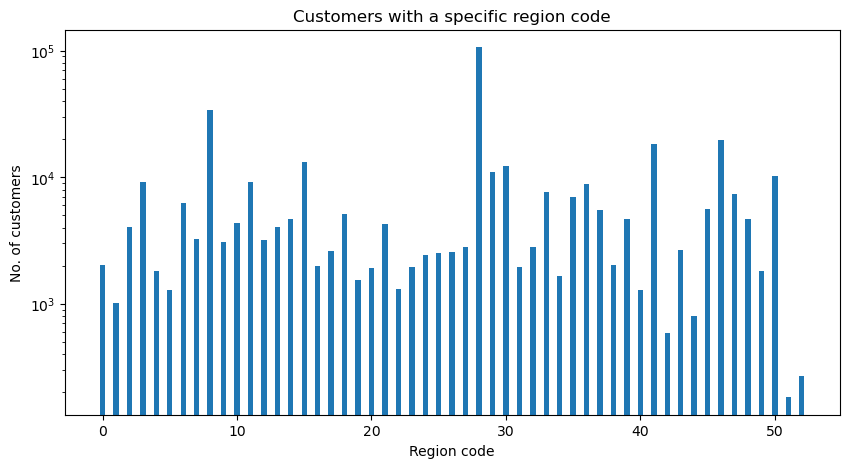

In [7]:
data = X_le.Region_Code.value_counts()
region_code = list(data.index.tolist())
customers = list(data.values.tolist())

fig = plt.figure(figsize = (10, 5))
plt.bar(region_code, customers,
        width = 0.4, log=True)
 
plt.xlabel("Region code")
plt.ylabel("No. of customers")
plt.title("Customers with a specific region code")
plt.show()

There are no really small categories, but still - the smallest one has 183 samples and the biggest one has over 100k samples. Please note that this bar has a logarithmic scale.

Next, I'll calculate score with all of the Region_Code categories transformed by One Hot Encoder:

In [11]:
X_rc_ohe = X_le_psc_te_rc.drop(columns=selected_to_remove)
rc_ohe = pd.get_dummies(X_rc_ohe["Region_Code"], prefix="Region_Code")
X_rc_ohe = pd.concat([X_rc_ohe, rc_ohe], axis=1)

encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'])
transformer = PowerTransformer()
model = make_pipeline(encoder, transformer, lgbm)

cross_val_score(model, X_rc_ohe, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()

/home/jsowa/anaconda3/envs/healthenv/lib/python3.11/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthenv/lib/python3.11/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthenv/lib/python3.11/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthenv/lib/python3.11/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthenv/lib/python3.11/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/

0.8582841565900503

The result with all of the Region_Code columns after One Hot Encoding is lower than without them, so I'll try to add only some of them. The algorithm will be fairly similar to that from the "feature selection" paragraph, I'll aim to add a column during each iteration rather than eliminating it (in this case, a backward selection might not even obtain a result before the Region_Code OHE):

In [7]:
# TODO: D.R.Y. - look at "feature selection" paragraph
def forward_selection(X, y, fixed_columns, path):
    encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'])
    transformer = PowerTransformer()
    model = make_pipeline(encoder, transformer, lgbm)

    full_cycle_iter = 2 # TODO: set 0
    #TODO: set empty array
    columns_to_add = ['Region_Code_0.0', 'Region_Code_38.0', 'Region_Code_43.0', 'Region_Code_50.0', 'Region_Code_52.0', 'Region_Code_10.0', 'Region_Code_49.0']

    while True:
        full_cycle_iter += 1
        columns_to_add_len_before_cycle = len(columns_to_add)
        print("Starting full cycle number " + str(full_cycle_iter))
        selection_columns = [col for col in rc_ohe.columns if col not in fixed_columns and col not in columns_to_add]
        print("Number of iters in this cycle: " + str(len(selection_columns)))
        base_score = cross_val_score(model, X[fixed_columns + columns_to_add], y, cv=10, scoring='roc_auc', n_jobs=-1).mean()
        print("Calculated base score: " + str(base_score))
        counter=0
        print("Finished iterations: ", end='')
        for column in selection_columns:
            score_with_column = cross_val_score(model, X[fixed_columns + columns_to_add + [column]], y, cv=10, scoring='roc_auc', n_jobs=-1).mean()
            counter += 1
            print(str(counter) + ",", end='')
            if score_with_column >= base_score:
                base_score = score_with_column
                columns_to_add += [column]

        if columns_to_add_len_before_cycle == len(columns_to_add):
            print()
            print("No columns added in this cycle")
            break

        save_print_result(base_score, columns_to_add, full_cycle_iter, path, " columns was added")

fixed_columns = [x for x in X_rc_ohe if x not in rc_ohe.columns]
# forward_selection(X_rc_ohe, y, fixed_columns, 'results/columns_to_add_rc')

Because the calculations are lengthy, I commented out the line with function execution. I'll just load the results from file and reevaluate the model here:

In [3]:
columns_to_add = pd.read_csv('results/columns_to_add_rc3.csv', index_col=0)["0"].tolist()
print("Added columns: ")
print(columns_to_add)
rc_ohe_score = cross_val_score(model, X_rc_ohe[fixed_columns + columns_to_add], y, cv=10, scoring='roc_auc', n_jobs=-1).mean()
rc_ohe_score

Added columns: 
['Region_Code_0.0', 'Region_Code_38.0', 'Region_Code_43.0', 'Region_Code_50.0', 'Region_Code_52.0', 'Region_Code_10.0', 'Region_Code_49.0', 'Region_Code_44.0']


/home/jsowa/anaconda3/envs/healthenv/lib/python3.11/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthenv/lib/python3.11/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthenv/lib/python3.11/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthenv/lib/python3.11/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthenv/lib/python3.11/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/

0.858464319908733

With four additional columns, the model gave a slightly higher result.

Outside of this notebook, I used backward selection to choose features, but the execution time was very long, and the final model had lower performance.

## 12. Partial PowerTransformer

PowerTransformer consumes a significant portion of the total computation time. Is it possible to achieve the same (or even higher) score by transforming only a subset of the features? I'll try to use an algorithm very similar to the one from backward selection after adding the Policy_Sales_Channel OHE columns. This code will only try to eliminate column transformations, not the columns themselves.

In [8]:
def choose_columns_to_transform(X):
    encoder = TargetEncoder(cols=['Region_Code', 'Policy_Sales_Channel'])
    full_cycle_iter = 0
    columns_without_transformer = []
    while True:
        all_columns = [x for x in X.columns.values if x not in columns_without_transformer]
        full_cycle_iter += 1
        print("Starting full cycle number " + str(full_cycle_iter))
        print("All columns number: " + str(len(all_columns)))
        columns_wo_tran_len_before_cycle = len(columns_without_transformer)
        transformer = ColumnTransformer(transformers=[('pwrtrans', PowerTransformer(), all_columns)], remainder='passthrough')
        model = make_pipeline(encoder, transformer, lgbm)
        base_score = cross_val_score(model, X, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()
        print("Base score: " + str(base_score))
        counter = 0
        print("Iterations finished: ", end='')
        for column in all_columns:
            columns_for_transformer = [x for x in all_columns if x not in columns_without_transformer + [column]]
            transformer = ColumnTransformer(transformers=[('pwrtrans', PowerTransformer(), columns_for_transformer)], remainder='passthrough')
            model = make_pipeline(encoder, transformer, lgbm)

            score = cross_val_score(model, X, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()
            counter += 1
            print(str(counter), end='')

            if score >= base_score:
                base_score = score
                print("Score for transformer without " + column + " column: " + str(score))
                columns_without_transformer += [column]

        if columns_wo_tran_len_before_cycle == len(columns_without_transformer):
            print("No columns added in this cycle")
            break

        pd.Series(columns_without_transformer).to_csv(
            'results/columns_without_transformer' + str(full_cycle_iter) + '.csv')
        print("Score after " + str(full_cycle_iter) + " cycle: " + str(base_score))
        print(str(len(columns_without_transformer)) + " columns was removed")
        print()


fixed_columns = [x for x in X_rc_ohe if x not in rc_ohe.columns]
X_reduce_te = X_rc_ohe[fixed_columns + columns_to_add]
# choose_columns_to_transform(X_reduce_te)

Again - this algorithm takes quite long time to execute, so here I will only load result:

In [4]:
columns_without_transformer = pd.read_csv('results/columns_without_transformer3.csv', index_col=0)["0"].to_list()
len(columns_without_transformer)

51

TODO: add info

In [6]:
encoder = TargetEncoder(cols=['Region_Code', 'Policy_Sales_Channel'])
transformer = ColumnTransformer(transformers=[('pwrtrans', PowerTransformer(), columns_for_transformer)], remainder='passthrough')
model = make_pipeline(encoder, transformer, lgbm)
wo_transformer_score = cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()
wo_transformer_score

0.8585066249405937

We have little higher score (about +0,00004), but the model is much slightly faster without transforming these columns.

## 13. TargetEncoding on Vehicle_Age

In [7]:
X_vage_te = X_reduce_te.copy()

encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code', 'Vehicle_Age'])
model = make_pipeline(encoder, transformer, lgbm)

cross_val_score(model, X_vage_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()

0.8581453563442667

It doesn't improve the result (also with additional original Vehicle_Age column).

## 14. Remove columns (backward selection)

In [13]:
def choose_columns_to_drop(X):
    encoder_columns = ['Region_Code', 'Policy_Sales_Channel']
    full_cycle_iter = 0
    columns_to_drop = []
    while True:
        all_columns = [x for x in X.columns.values if x not in columns_to_drop]
        full_cycle_iter += 1
        print("Starting full cycle number " + str(full_cycle_iter))
        print("All columns number: " + str(len(all_columns)))
        columns_to_drop_len_before_cycle = len(columns_to_drop)
        inner_columns_for_transformer = [elem for elem in columns_for_transformer if elem not in columns_to_drop]
        transformer = ColumnTransformer(transformers=[('pwrtrans', PowerTransformer(), inner_columns_for_transformer)], remainder='passthrough')
        inner_encoder_columns = [elem for elem in encoder_columns if elem not in columns_to_drop]
        encoder = TargetEncoder(cols=inner_encoder_columns)
        model = make_pipeline(encoder, transformer, lgbm)
        base_score = cross_val_score(model, X.drop(columns=columns_to_drop), y, cv=10, scoring='roc_auc', n_jobs=-1).mean()
        print("Base score: " + str(base_score))
        counter = 0
        print("Iterations finished: ", end='')
        for column in all_columns:
            inner_columns_for_transformer = [elem for elem in columns_for_transformer if elem not in columns_to_drop + [column]]
            transformer = ColumnTransformer(transformers=[('pwrtrans', PowerTransformer(), inner_columns_for_transformer)], remainder='passthrough')
            inner_encoder_columns = [elem for elem in encoder_columns if elem not in columns_to_drop + [column]]
            encoder = TargetEncoder(cols=inner_encoder_columns)
            model = make_pipeline(encoder, transformer, lgbm)

            score = cross_val_score(model, X.drop(columns=columns_to_drop + [column]), y, cv=10, scoring='roc_auc', n_jobs=-1).mean()
            counter += 1
            print(str(counter), end='')

            if score >= base_score:
                base_score = score
                print("Score for model without " + column + " column: " + str(score))
                columns_to_drop += [column]

        if columns_to_drop_len_before_cycle == len(columns_to_drop):
            print("No columns added in this cycle")
            break

        pd.Series(columns_to_drop).to_csv(
            'results/columns_to_drop' + str(full_cycle_iter) + '.csv')
        print("Score after " + str(full_cycle_iter) + " cycle: " + str(base_score))
        print(str(len(columns_to_drop)) + " columns was removed")
        print()


choose_columns_to_drop(X_reduce_te)

Starting full cycle number 1
All columns number: 57
Base score: 0.8585066249405937
Iterations finished: 12345678910111213141516Score for model without Policy_Sales_Channel_19.0 column: 0.8585071454291466
171819202122Score for model without Policy_Sales_Channel_36.0 column: 0.8585074220007648
232425262728Score for model without Policy_Sales_Channel_116.0 column: 0.8585078599189225
293031323334Score for model without Policy_Sales_Channel_139.0 column: 0.8585078599189225
35Score for model without Policy_Sales_Channel_140.0 column: 0.8585078599189225
36373839404142434445464748495051Score for model without Region_Code_38.0 column: 0.8585078599189225
525354Score for model without Region_Code_52.0 column: 0.8585078599189225
555657Score after 1 cycle: 0.8585078599189225
7 columns was removed

Starting full cycle number 2
All columns number: 50
Base score: 0.8585078599189225
Iterations finished: 1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950No column

In [14]:
columns_to_drop = pd.read_csv('results/columns_to_drop1.csv', index_col=0)["0"].to_list()
columns_to_drop

['Policy_Sales_Channel_19.0',
 'Policy_Sales_Channel_36.0',
 'Policy_Sales_Channel_116.0',
 'Policy_Sales_Channel_139.0',
 'Policy_Sales_Channel_140.0',
 'Region_Code_38.0',
 'Region_Code_52.0']

In [16]:
encoder = TargetEncoder(cols=['Region_Code', 'Policy_Sales_Channel'])
transformer = ColumnTransformer(transformers=[('pwrtrans', PowerTransformer(), columns_for_transformer)], remainder='passthrough')
model = make_pipeline(encoder, transformer, lgbm)
X_dropped = X_reduce_te.drop(columns=columns_to_drop)
dropped_score = cross_val_score(model, X_dropped, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()
dropped_score

0.8585078599189225

## 14. Oversampling/SMOTE
Oversampling is a popular technique for assisting with imbalanced dataset classification. It supplies multiple copies of the smaller class to obtain the desired ratio between class sizes.

The second is called SMOTE ("Synthetic Minority Over-sampling Technique"). The main idea of this tool is the same, but instead of using copies, it generates samples similar to the real ones.

In [17]:
oversample = RandomOverSampler()

model = Pipeline([('over', oversample), ('enc', encoder), ('trans', transformer), ('lgbm', lgbm)])
print("Score of RandomOverSampler before encoder: " + str(cross_val_score(model, X_dropped, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()))

model = Pipeline([('enc', encoder), ('over', oversample), ('trans', transformer), ('lgbm', lgbm)])
print("Score of RandomOverSampler before transformer: " + str(cross_val_score(model, X_dropped, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()))

model = Pipeline([('enc', encoder), ('trans', transformer), ('over', oversample), ('lgbm', lgbm)])
print("Score of RandomOverSampler before LGBM: " + str(cross_val_score(model, X_dropped, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()))

smote = SMOTE()
model = Pipeline([('smt', smote), ('enc', encoder), ('trans', transformer), ('lgbm', lgbm)])
print("Score of SMOTE before encoder: " + str(cross_val_score(model, X_dropped, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()))

model = Pipeline([('enc', encoder), ('smt', smote), ('trans', transformer), ('lgbm', lgbm)])
print("Score of SMOTE before transformer: " + str(cross_val_score(model, X_dropped, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()))

model = Pipeline([('enc', encoder), ('trans', transformer), ('smt', smote), ('lgbm', lgbm)])
print("Score of SMOTE before LGBM: " + str(cross_val_score(model, X_dropped, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()))

Score of RandomOverSampler before encoder: 0.8581936956212063
Score of RandomOverSampler before transformer: 0.8581407181714195
Score of RandomOverSampler before LGBM: 0.8581682834013602
Score of SMOTE before encoder: 0.8420520735940082
Score of SMOTE before transformer: 0.8411008737345622
Score of SMOTE before LGBM: 0.850211346394674


Any variant didn't improve the result. I tried to use the sampler as another step in the pipeline, but it returned an even worse score. One of them is really close ("RandomOverSampler before LGBM"), but it's still less than without it.

## 15. LGBM Model tuning

In [6]:
# TODO: calculate more trials

trials_number = 200

def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1.0)
    max_depth = -1
    depth_limit = trial.suggest_categorical("depth_limit", [True, False])
    if depth_limit is True:
        max_depth = trial.suggest_int("max_depth", 2, 9)
    num_leaves_pow = trial.suggest_int("num_leaves_pow", 2, 10)
    num_leaves = 2 ** num_leaves_pow
    n_estimators = trial.suggest_int('n_estimators', 50, 2750)
    subsample = trial.suggest_uniform('subsample', 0.3, 1.0)
    class_weight = trial.suggest_categorical("class_weight", [None, 'balanced'])
    te_smoothing = trial.suggest_loguniform("te_smoothing", 0.05, 5.0)
    
    lgbm = LGBMClassifier(random_state=42, verbose=-1, learning_rate=learning_rate, max_depth=max_depth, num_leaves=num_leaves, n_estimators=n_estimators, subsample=subsample, class_weight=class_weight)
    encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'], smoothing=te_smoothing)
    transformer = ColumnTransformer(transformers=[('pwrtrans', PowerTransformer(), columns_for_transformer)], remainder='passthrough')
    model = make_pipeline(encoder, transformer, lgbm)

    score = cross_val_score(model, X_dropped, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()
    print("  ROC AUC: {}".format(score))

    print("  Params for trial " + str(trial.number) + ": ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    return score

study_name = 'lgbm-study2'
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(study_name=study_name, direction="maximize", storage=storage_name, load_if_exists=True,)


study.enqueue_trial({
        "learning_rate": 0.01,
        "depth_limit": False,
        "max_depth": 5,
        "num_leaves_pow": 5,
        "n_estimators": 100,
        "subsample": 0.7,
        "class_weight": None,
        "te_smoothing": 1.0,
    })

optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=trials_number)

  ROC AUC: 0.8559796003897515
  Params for trial 33: 
    learning_rate: 0.01
    depth_limit: False
    num_leaves_pow: 5
    n_estimators: 100
    subsample: 0.7
    class_weight: None
    te_smoothing: 1.0
  ROC AUC: 0.8587896716790423
  Params for trial 34: 
    learning_rate: 0.00511230057733651
    depth_limit: True
    max_depth: 8
    num_leaves_pow: 8
    n_estimators: 1529
    subsample: 0.5340887160431816
    class_weight: None
    te_smoothing: 0.18034411375355414
  ROC AUC: 0.8586428080976148
  Params for trial 35: 
    learning_rate: 0.004282499696481137
    depth_limit: True
    max_depth: 7
    num_leaves_pow: 10
    n_estimators: 1557
    subsample: 0.4825469154591017
    class_weight: None
    te_smoothing: 0.1598902866928929
  ROC AUC: 0.85508170367236
  Params for trial 36: 
    learning_rate: 0.03178899556710525
    depth_limit: True
    max_depth: 8
    num_leaves_pow: 9
    n_estimators: 1205
    subsample: 0.6178964886727328
    class_weight: None
    te_smoothi

  ROC AUC: 0.8588028205883408
  Params for trial 64: 
    learning_rate: 0.006520868306421942
    depth_limit: True
    max_depth: 7
    num_leaves_pow: 9
    n_estimators: 1296
    subsample: 0.5617571946209461
    class_weight: None
    te_smoothing: 0.19596127280438935
  ROC AUC: 0.8587609079473724
  Params for trial 65: 
    learning_rate: 0.013349234320425164
    depth_limit: True
    max_depth: 7
    num_leaves_pow: 10
    n_estimators: 832
    subsample: 0.6700662600892158
    class_weight: None
    te_smoothing: 0.4089457959334153
  ROC AUC: 0.8588290133601377
  Params for trial 66: 
    learning_rate: 0.006794058871922683
    depth_limit: True
    max_depth: 7
    num_leaves_pow: 9
    n_estimators: 1367
    subsample: 0.5649643883299822
    class_weight: None
    te_smoothing: 0.05484141916013769
  ROC AUC: 0.8587237848836546
  Params for trial 67: 
    learning_rate: 0.0066094123141726335
    depth_limit: True
    max_depth: 6
    num_leaves_pow: 9
    n_estimators: 1325
   

  ROC AUC: 0.8455683169431174
  Params for trial 95: 
    learning_rate: 0.2753952176234846
    depth_limit: True
    max_depth: 6
    num_leaves_pow: 10
    n_estimators: 1098
    subsample: 0.44281302066050704
    class_weight: None
    te_smoothing: 1.5626433475797197
  ROC AUC: 0.8589426655591297
  Params for trial 96: 
    learning_rate: 0.015963242473749167
    depth_limit: True
    max_depth: 6
    num_leaves_pow: 10
    n_estimators: 919
    subsample: 0.47525300917323426
    class_weight: None
    te_smoothing: 1.2857990959080767
  ROC AUC: 0.8582798855609678
  Params for trial 97: 
    learning_rate: 0.010251615931714853
    depth_limit: True
    max_depth: 5
    num_leaves_pow: 10
    n_estimators: 910
    subsample: 0.5306492309360102
    class_weight: None
    te_smoothing: 1.3146047008228654
  ROC AUC: 0.8582583541316682
  Params for trial 98: 
    learning_rate: 0.048393100692714935
    depth_limit: True
    max_depth: 6
    num_leaves_pow: 10
    n_estimators: 610
    s

  ROC AUC: 0.858751973954384
  Params for trial 126: 
    learning_rate: 0.009474539913706847
    depth_limit: True
    max_depth: 6
    num_leaves_pow: 10
    n_estimators: 942
    subsample: 0.500986440786999
    class_weight: None
    te_smoothing: 1.837153323765209
  ROC AUC: 0.8586050183367693
  Params for trial 127: 
    learning_rate: 0.028610944306814778
    depth_limit: True
    max_depth: 6
    num_leaves_pow: 9
    n_estimators: 863
    subsample: 0.46410849338328813
    class_weight: None
    te_smoothing: 1.1022117887686034
  ROC AUC: 0.8586690120244167
  Params for trial 128: 
    learning_rate: 0.016850797735326828
    depth_limit: True
    max_depth: 6
    num_leaves_pow: 10
    n_estimators: 1339
    subsample: 0.5129439488153282
    class_weight: None
    te_smoothing: 0.952845921702498
  ROC AUC: 0.8585985720618583
  Params for trial 129: 
    learning_rate: 0.006613365489053833
    depth_limit: True
    max_depth: 7
    num_leaves_pow: 10
    n_estimators: 1002
    

  ROC AUC: 0.8587704499716503
  Params for trial 157: 
    learning_rate: 0.010417668459452072
    depth_limit: True
    max_depth: 6
    num_leaves_pow: 10
    n_estimators: 873
    subsample: 0.5004892161966431
    class_weight: None
    te_smoothing: 1.019177810757933
  ROC AUC: 0.8589026919205629
  Params for trial 158: 
    learning_rate: 0.014909209747403578
    depth_limit: True
    max_depth: 6
    num_leaves_pow: 10
    n_estimators: 713
    subsample: 0.5105057176626757
    class_weight: None
    te_smoothing: 0.6627845070034211
  ROC AUC: 0.8577800686588521
  Params for trial 159: 
    learning_rate: 0.052877357149187953
    depth_limit: True
    max_depth: 5
    num_leaves_pow: 10
    n_estimators: 1070
    subsample: 0.5413207491804037
    class_weight: None
    te_smoothing: 1.2081253790873092
  ROC AUC: 0.8588052429638336
  Params for trial 160: 
    learning_rate: 0.031469299844574104
    depth_limit: True
    max_depth: 6
    num_leaves_pow: 10
    n_estimators: 610
  

  ROC AUC: 0.8588785669903309
  Params for trial 188: 
    learning_rate: 0.03178772239581997
    depth_limit: True
    max_depth: 5
    num_leaves_pow: 10
    n_estimators: 800
    subsample: 0.9797032976234115
    class_weight: None
    te_smoothing: 0.33684209386973296
  ROC AUC: 0.8588882944360728
  Params for trial 189: 
    learning_rate: 0.023702918665535866
    depth_limit: True
    max_depth: 5
    num_leaves_pow: 10
    n_estimators: 594
    subsample: 0.9165767809926211
    class_weight: None
    te_smoothing: 0.4282766261125346
  ROC AUC: 0.8578860463671898
  Params for trial 190: 
    learning_rate: 0.020443456581065122
    depth_limit: True
    max_depth: 5
    num_leaves_pow: 10
    n_estimators: 372
    subsample: 0.9458926716908905
    class_weight: None
    te_smoothing: 0.2596698839686769
  ROC AUC: 0.8588904822248236
  Params for trial 191: 
    learning_rate: 0.029859357230436215
    depth_limit: True
    max_depth: 5
    num_leaves_pow: 6
    n_estimators: 475
   

  ROC AUC: 0.8587629462735213
  Params for trial 219: 
    learning_rate: 0.023866602184521437
    depth_limit: True
    max_depth: 4
    num_leaves_pow: 10
    n_estimators: 809
    subsample: 0.9875847908988903
    class_weight: None
    te_smoothing: 0.6200546949038589
  ROC AUC: 0.8588568989724571
  Params for trial 220: 
    learning_rate: 0.017943455215386764
    depth_limit: True
    max_depth: 5
    num_leaves_pow: 10
    n_estimators: 769
    subsample: 0.9973966332533118
    class_weight: None
    te_smoothing: 0.41103256936066257
  ROC AUC: 0.858922946490025
  Params for trial 221: 
    learning_rate: 0.024497027064584266
    depth_limit: True
    max_depth: 5
    num_leaves_pow: 10
    n_estimators: 816
    subsample: 0.9759675363763756
    class_weight: None
    te_smoothing: 0.42484986999836427
  ROC AUC: 0.8587792988175714
  Params for trial 222: 
    learning_rate: 0.047829199775912996
    depth_limit: True
    max_depth: 5
    num_leaves_pow: 4
    n_estimators: 845
  

Model tuning is a time-consuming process, so in the cell above I have commented the line with computations. Here I'll only take the final parameters, train model, and show score: 

In [7]:
print("\nBest trial:")
trial = study.best_trial

print("  ROC AUC: {}".format(trial.value))
xgb_tuning = trial.value

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


Best trial:
  ROC AUC: 0.8590190671837779
  Params: 
    class_weight: None
    depth_limit: True
    learning_rate: 0.023897824666980833
    max_depth: 5
    n_estimators: 729
    num_leaves_pow: 10
    subsample: 0.9744252904062313
    te_smoothing: 0.367814213843938


In [9]:
learning_rate = 0.023897824666980833
max_depth = 5
num_leaves_pow = 10
num_leaves = 2 ** num_leaves_pow
n_estimators = 729
subsample = 0.9744252904062313
class_weight = None
te_smoothing = 0.367814213843938

transformer = ColumnTransformer(transformers=[('pwrtrans', PowerTransformer(), columns_for_transformer)], remainder='passthrough')    
lgbm = LGBMClassifier(random_state=42, verbose=-1, learning_rate=learning_rate, max_depth=max_depth, num_leaves=num_leaves, n_estimators=n_estimators, subsample=subsample, class_weight=class_weight)
encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'], smoothing=te_smoothing)
model = make_pipeline(encoder, transformer, lgbm)

lgbm_tuning = cross_val_score(model, X_dropped, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()
lgbm_tuning

0.8590190671837779

The model provided a noticeable boost. With a lower learning rate of \~0.01 (default 0.1), it achieves a score of ***0.8588986626649424***. Much higher estimators number 2371 (default 100) extend execution time. Optuna decided to use some techniques to curb the overtraining problem: a lower subsample ratio of the training instance (\~0.7 instead of 1.0) and a fixed maximum tree depth.

## 16. XGB model
eXtreme Gradient Boosting is a more powerful but slower algorithm. LightGBM can sometimes obtain higher performance, but usually XGBoost has a slightly better result and significantly slower execution time. A detailed comparison of these algorithms would be too long for this article, so I encourage you to watch [this video](https://www.youtube.com/watch?v=5CWwwtEM2TA) if you're interested in the topic.

In [1]:
# TODO: remove cell

from common import *
import warnings
warnings.filterwarnings("ignore")

psc_ohe = pd.get_dummies(X_le["Policy_Sales_Channel"], prefix="Policy_Sales_Channel")

counts = X_le["Policy_Sales_Channel"].value_counts()
counts = counts[counts == 1]
columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(x), counts.index.tolist()))
psc_ohe = psc_ohe.drop(columns=columns_to_remove)

X_le_psc = pd.concat([X_le, psc_ohe], axis=1)
value_counts = X_le_psc["Policy_Sales_Channel"].value_counts().index
columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(value_counts[x]), [*range(147, 86, -1)]))
columns_to_remove += ['Vintage']
X_le_psc_te = X_le_psc.drop(columns=columns_to_remove).copy()
X_le_psc_te['Policy_Sales_Channel_te'] = X_le_psc_te['Policy_Sales_Channel']
X_le_psc_te_rc = X_le_psc_te.copy()
X_le_psc_te_rc['Region_Code_te'] = X_le_psc_te_rc['Region_Code']
selected_to_remove = pd.read_csv('results/columns_to_remove1.csv', index_col=0)["0"]
X_rc_ohe = X_le_psc_te_rc.drop(columns=selected_to_remove)
rc_ohe = pd.get_dummies(X_rc_ohe["Region_Code"], prefix="Region_Code")
X_rc_ohe = pd.concat([X_rc_ohe, rc_ohe], axis=1)

rc_ohe = pd.get_dummies(X_rc_ohe["Region_Code"], prefix="Region_Code")

columns_to_add = pd.read_csv('results/columns_to_add_rc3.csv', index_col=0)["0"].tolist()
fixed_columns = [x for x in X_rc_ohe if x not in rc_ohe.columns]
X_reduce_te = X_rc_ohe[fixed_columns + columns_to_add]

columns_to_drop = pd.read_csv('results/columns_to_drop1.csv', index_col=0)["0"].to_list()
X_dropped = X_reduce_te.drop(columns=columns_to_drop)

columns_without_transformer = pd.read_csv('results/columns_without_transformer3.csv', index_col=0)["0"].to_list()
columns_for_transformer = X_reduce_te.drop(columns=columns_without_transformer).columns.values.tolist()
transformer = ColumnTransformer(transformers=[('pwrtrans', PowerTransformer(), columns_for_transformer)], remainder='passthrough')

In [9]:
def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1.0)
    max_depth = trial.suggest_int("max_depth", 2, 10)
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    subsample = trial.suggest_uniform('subsample', 0.4, 1.0)
    te_smoothing = trial.suggest_loguniform("te_smoothing", 0.05, 10.0)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 7)
    gamma = trial.suggest_uniform("gamma", 0.0, 1.0)
    colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.3, 1.0)
    reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-3, 1e2)

    
    xgb = XGBClassifier(random_state=42, eval_metric="logloss", learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, subsample=subsample, min_child_weight=min_child_weight, gamma=gamma, colsample_bytree=colsample_bytree, reg_alpha=reg_alpha)
    encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'], smoothing=te_smoothing)
    model = make_pipeline(encoder, transformer, xgb)

    score = cross_val_score(model, X_dropped, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()
    print("  ROC AUC: {}".format(score))

    print("  Params for trial " + str(trial.number) + ": ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    
    return score

In [3]:
trials_number = 200

study_name = 'xgb-model-study2'
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(study_name=study_name, direction="maximize", storage=storage_name, load_if_exists=True,)

study.enqueue_trial({
        "learning_rate": 0.1,
        "max_depth": 3,
        "min_child_weight": 5,
        "n_estimators": 100,
        "subsample": 0.9,
        "class_weight": None,
        "te_smoothing": 1.0,
        "gamma": 0.0,
        "colsample_bytree": 0.75,
        "reg_alpha": 0.0
    })

optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=trials_number)

[I 2023-01-27 09:58:39,702] Using an existing study with name 'xgb-model-study2' instead of creating a new one.


  ROC AUC: 0.8585455074243052
  Params for trial 127: 
    learning_rate: 0.016597273755705733
    max_depth: 6
    n_estimators: 466
    subsample: 0.8051880484545443
    te_smoothing: 0.09812329489610778
    min_child_weight: 7
    gamma: 0.1733176225040016
    colsample_bytree: 0.8882769242878706
    reg_alpha: 0.005109886735604757
  ROC AUC: 0.8579670419354292
  Params for trial 128: 
    learning_rate: 0.009108583993746894
    max_depth: 8
    n_estimators: 354
    subsample: 0.7931543024079238
    te_smoothing: 0.20435467031317991
    min_child_weight: 6
    gamma: 0.6687719507174467
    colsample_bytree: 0.9063913417000119
    reg_alpha: 0.003762014834780283
  ROC AUC: 0.8591388992281942
  Params for trial 129: 
    learning_rate: 0.019275461808796305
    max_depth: 7
    n_estimators: 485
    subsample: 0.7769993723755348
    te_smoothing: 0.12649381256447653
    min_child_weight: 6
    gamma: 0.7388952572454905
    colsample_bytree: 0.8217680388370598
    reg_alpha: 0.00259473

  ROC AUC: 0.8591839854511656
  Params for trial 152: 
    learning_rate: 0.032504292154516425
    max_depth: 6
    n_estimators: 490
    subsample: 0.8980974747590673
    te_smoothing: 0.39889616285262436
    min_child_weight: 6
    gamma: 0.7009527953507672
    colsample_bytree: 0.7546270140104863
    reg_alpha: 0.003060555076457799
  ROC AUC: 0.8588987838910113
  Params for trial 153: 
    learning_rate: 0.05364450502549473
    max_depth: 6
    n_estimators: 491
    subsample: 0.8936276005960473
    te_smoothing: 0.3348306958121241
    min_child_weight: 6
    gamma: 0.7011338396756586
    colsample_bytree: 0.7520485583232195
    reg_alpha: 0.002878325175238929
  ROC AUC: 0.8592046680660047
  Params for trial 154: 
    learning_rate: 0.03336910541062861
    max_depth: 6
    n_estimators: 500
    subsample: 0.9209430770734947
    te_smoothing: 0.4174751700185831
    min_child_weight: 6
    gamma: 0.7225960993404235
    colsample_bytree: 0.7202418257594221
    reg_alpha: 0.001942031122

  ROC AUC: 0.8590515681693608
  Params for trial 177: 
    learning_rate: 0.05073572363568691
    max_depth: 6
    n_estimators: 454
    subsample: 0.9528485650916259
    te_smoothing: 0.8196448062695553
    min_child_weight: 6
    gamma: 0.6509280471886236
    colsample_bytree: 0.6644453033248119
    reg_alpha: 0.0014661996551494927
  ROC AUC: 0.8574645640163222
  Params for trial 178: 
    learning_rate: 0.1586194558224751
    max_depth: 5
    n_estimators: 460
    subsample: 0.9068793359596538
    te_smoothing: 0.6326076048084313
    min_child_weight: 6
    gamma: 0.6652040710092879
    colsample_bytree: 0.6183193600427351
    reg_alpha: 0.0023629082824320265
  ROC AUC: 0.8592637893388761
  Params for trial 179: 
    learning_rate: 0.03434309183258278
    max_depth: 6
    n_estimators: 474
    subsample: 0.9196131842668696
    te_smoothing: 0.7326886603626148
    min_child_weight: 7
    gamma: 0.678742601777611
    colsample_bytree: 0.6490380511594844
    reg_alpha: 0.00100364171885

  ROC AUC: 0.8591742478275565
  Params for trial 202: 
    learning_rate: 0.043950807563349924
    max_depth: 6
    n_estimators: 462
    subsample: 0.9160723964356621
    te_smoothing: 0.44736392919908624
    min_child_weight: 7
    gamma: 0.6840160686009049
    colsample_bytree: 0.6496492367269928
    reg_alpha: 0.09302085170493946
  ROC AUC: 0.8591808170379386
  Params for trial 203: 
    learning_rate: 0.025951794470188458
    max_depth: 6
    n_estimators: 470
    subsample: 0.907829342207298
    te_smoothing: 0.5839439738033508
    min_child_weight: 7
    gamma: 0.7613796291615047
    colsample_bytree: 0.6703014134085858
    reg_alpha: 0.22542510558582857
  ROC AUC: 0.8591968462541347
  Params for trial 204: 
    learning_rate: 0.03576951384469866
    max_depth: 6
    n_estimators: 440
    subsample: 0.9549412177451464
    te_smoothing: 0.5170161217977906
    min_child_weight: 7
    gamma: 0.6520723069938527
    colsample_bytree: 0.6861892702760815
    reg_alpha: 0.08205172409219

  ROC AUC: 0.8593345798331038
  Params for trial 227: 
    learning_rate: 0.0430220497412304
    max_depth: 6
    n_estimators: 419
    subsample: 0.897968292170655
    te_smoothing: 0.3792655924555768
    min_child_weight: 7
    gamma: 0.7021504771939594
    colsample_bytree: 0.5509921232773644
    reg_alpha: 3.6984658410645266
  ROC AUC: 0.8592812147394022
  Params for trial 228: 
    learning_rate: 0.04559841954580165
    max_depth: 6
    n_estimators: 404
    subsample: 0.8911330295544532
    te_smoothing: 0.36630696280679276
    min_child_weight: 7
    gamma: 0.6927627129365904
    colsample_bytree: 0.579134587480685
    reg_alpha: 2.903563662007098
  ROC AUC: 0.8589790492678805
  Params for trial 229: 
    learning_rate: 0.07707701137715262
    max_depth: 6
    n_estimators: 405
    subsample: 0.8889104744047543
    te_smoothing: 0.34097398531869016
    min_child_weight: 7
    gamma: 0.7166083388149739
    colsample_bytree: 0.5451719365665965
    reg_alpha: 3.62103883608892
  ROC

  ROC AUC: 0.8588435587367869
  Params for trial 252: 
    learning_rate: 0.08673004841921036
    max_depth: 6
    n_estimators: 389
    subsample: 0.8882637313805842
    te_smoothing: 0.19899863191795686
    min_child_weight: 7
    gamma: 0.7588850615966354
    colsample_bytree: 0.5061229201159332
    reg_alpha: 4.868767652479808
  ROC AUC: 0.8592892947236329
  Params for trial 253: 
    learning_rate: 0.05056638982380078
    max_depth: 6
    n_estimators: 400
    subsample: 0.8509522988723007
    te_smoothing: 0.23902651678654377
    min_child_weight: 7
    gamma: 0.7748524121381699
    colsample_bytree: 0.5516882298254816
    reg_alpha: 6.028876580412612
  ROC AUC: 0.8591168863457028
  Params for trial 254: 
    learning_rate: 0.06595020780669307
    max_depth: 6
    n_estimators: 401
    subsample: 0.8489771116197178
    te_smoothing: 0.24710613585804775
    min_child_weight: 7
    gamma: 0.787332618302102
    colsample_bytree: 0.5502367782956569
    reg_alpha: 6.253588373961864
  

  ROC AUC: 0.8593292501970742
  Params for trial 277: 
    learning_rate: 0.050259875050874335
    max_depth: 6
    n_estimators: 371
    subsample: 0.8512680005078257
    te_smoothing: 0.2647223790333181
    min_child_weight: 7
    gamma: 0.7455798392581099
    colsample_bytree: 0.5157366283629208
    reg_alpha: 2.765190717512154
  ROC AUC: 0.8593310520992532
  Params for trial 278: 
    learning_rate: 0.050288890423726196
    max_depth: 6
    n_estimators: 369
    subsample: 0.8472591894547954
    te_smoothing: 0.2566965258350305
    min_child_weight: 7
    gamma: 0.7951112575495356
    colsample_bytree: 0.5187526925953097
    reg_alpha: 2.699466640939923
  ROC AUC: 0.8586313917690382
  Params for trial 279: 
    learning_rate: 0.2213004519823814
    max_depth: 2
    n_estimators: 367
    subsample: 0.8514368105166357
    te_smoothing: 0.16544613837317446
    min_child_weight: 7
    gamma: 0.8094398924886967
    colsample_bytree: 0.5157378238443784
    reg_alpha: 2.8184464724494216
 

KeyboardInterrupt: 

In [ ]:
trials_number = 200

study_name = 'xgb-model-study2'
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(study_name=study_name, direction="maximize", storage=storage_name, load_if_exists=True,)

optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=trials_number)

  ROC AUC: 0.8593867732730212
  Params for trial 287: 
    learning_rate: 0.04385380589171324
    max_depth: 6
    n_estimators: 379
    subsample: 0.8466775093388172
    te_smoothing: 0.21043366510977338
    min_child_weight: 7
    gamma: 0.7394978537651908
    colsample_bytree: 0.5171639553741474
    reg_alpha: 3.3980435972716134
  ROC AUC: 0.8593277277293755
  Params for trial 288: 
    learning_rate: 0.046721340359672243
    max_depth: 6
    n_estimators: 382
    subsample: 0.833084434831743
    te_smoothing: 0.17750905592741542
    min_child_weight: 7
    gamma: 0.7469831453826463
    colsample_bytree: 0.5121138893085833
    reg_alpha: 3.23055695804574
  ROC AUC: 0.8593168897372776
  Params for trial 289: 
    learning_rate: 0.04754145045938493
    max_depth: 6
    n_estimators: 380
    subsample: 0.8678126746193444
    te_smoothing: 0.17502248420428584
    min_child_weight: 7
    gamma: 0.7543318939557839
    colsample_bytree: 0.5162004929553033
    reg_alpha: 3.167491482555145
 

In [11]:
trials_number = 200

study_name = 'xgb-model-study2'
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(study_name=study_name, direction="maximize", storage=storage_name, load_if_exists=True,)

optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=trials_number)

[I 2023-01-28 08:29:31,725] Using an existing study with name 'xgb-model-study2' instead of creating a new one.


  ROC AUC: 0.8593083480523859
  Params for trial 308: 
    learning_rate: 0.040799238743618564
    max_depth: 6
    n_estimators: 390
    subsample: 0.8938926575943822
    te_smoothing: 0.28146790499664304
    min_child_weight: 7
    gamma: 0.7773591411838139
    colsample_bytree: 0.5641032803469141
    reg_alpha: 5.923635516950847
  ROC AUC: 0.8590788632930899
  Params for trial 309: 
    learning_rate: 0.06565139269022606
    max_depth: 6
    n_estimators: 401
    subsample: 0.8465969948778406
    te_smoothing: 0.1319846862591225
    min_child_weight: 7
    gamma: 0.8062396324390406
    colsample_bytree: 0.5441241749315827
    reg_alpha: 5.3529368718492725
  ROC AUC: 0.8517876616002473
  Params for trial 310: 
    learning_rate: 4.887690599616617e-05
    max_depth: 6
    n_estimators: 388
    subsample: 0.8758847608527557
    te_smoothing: 0.2188841425610514
    min_child_weight: 7
    gamma: 0.7576412447833023
    colsample_bytree: 0.5346507444277717
    reg_alpha: 3.787189462890327

  ROC AUC: 0.8593157283411216
  Params for trial 333: 
    learning_rate: 0.03638708343624503
    max_depth: 6
    n_estimators: 414
    subsample: 0.8356515113886761
    te_smoothing: 0.1779837260426411
    min_child_weight: 7
    gamma: 0.7099074111766736
    colsample_bytree: 0.5085081219516357
    reg_alpha: 2.2753373595639093
  ROC AUC: 0.859066351686916
  Params for trial 334: 
    learning_rate: 0.027505239130569428
    max_depth: 6
    n_estimators: 377
    subsample: 0.8423264135657844
    te_smoothing: 0.16015254327151363
    min_child_weight: 7
    gamma: 0.786951211289598
    colsample_bytree: 0.5203918738049987
    reg_alpha: 3.443084241113558
  ROC AUC: 0.8593797208558762
  Params for trial 335: 
    learning_rate: 0.045912264234197524
    max_depth: 6
    n_estimators: 388
    subsample: 0.826514823661991
    te_smoothing: 0.23102485662559658
    min_child_weight: 7
    gamma: 0.7092871688136171
    colsample_bytree: 0.5001374815137145
    reg_alpha: 2.6553771932238432
 

  ROC AUC: 0.8457770523449624
  Params for trial 358: 
    learning_rate: 0.8678427400736214
    max_depth: 6
    n_estimators: 412
    subsample: 0.8958170301659053
    te_smoothing: 0.32940439784614783
    min_child_weight: 7
    gamma: 0.6999078473294175
    colsample_bytree: 0.5421645480911607
    reg_alpha: 3.823243150887567
  ROC AUC: 0.8590651122128484
  Params for trial 359: 
    learning_rate: 0.024467863253119348
    max_depth: 6
    n_estimators: 419
    subsample: 0.8767944712367507
    te_smoothing: 0.30910782602646975
    min_child_weight: 7
    gamma: 0.7173452717543791
    colsample_bytree: 0.5350061533503597
    reg_alpha: 4.648804809759374
  ROC AUC: 0.8585740880217102
  Params for trial 360: 
    learning_rate: 0.03651317537772177
    max_depth: 6
    n_estimators: 404
    subsample: 0.8648115734824178
    te_smoothing: 0.3374110804113788
    min_child_weight: 7
    gamma: 0.693645475523895
    colsample_bytree: 0.5518202152831898
    reg_alpha: 37.985894743494526
  

  ROC AUC: 0.8593518021870346
  Params for trial 383: 
    learning_rate: 0.03874694709736458
    max_depth: 7
    n_estimators: 396
    subsample: 0.845190741720898
    te_smoothing: 0.13161328034300993
    min_child_weight: 7
    gamma: 0.8724838818855358
    colsample_bytree: 0.44616147383902044
    reg_alpha: 6.263766686188959
  ROC AUC: 0.8593259321638967
  Params for trial 384: 
    learning_rate: 0.038616091709154914
    max_depth: 7
    n_estimators: 395
    subsample: 0.8491988077817856
    te_smoothing: 0.12934520181180276
    min_child_weight: 7
    gamma: 0.9428442088969369
    colsample_bytree: 0.42582990393584874
    reg_alpha: 6.980810035350597
  ROC AUC: 0.8589656875482982
  Params for trial 385: 
    learning_rate: 0.02259143071789936
    max_depth: 7
    n_estimators: 381
    subsample: 0.8551283035908105
    te_smoothing: 0.10901756848126236
    min_child_weight: 7
    gamma: 0.9111099245265585
    colsample_bytree: 0.43915896139069865
    reg_alpha: 7.56152759418284

  ROC AUC: 0.8585072902325346
  Params for trial 408: 
    learning_rate: 0.01981631016507406
    max_depth: 7
    n_estimators: 383
    subsample: 0.9073539911835121
    te_smoothing: 0.23290816194377692
    min_child_weight: 7
    gamma: 0.8999979985945479
    colsample_bytree: 0.5424039189731387
    reg_alpha: 20.356897305923084
  ROC AUC: 0.8592831835418488
  Params for trial 409: 
    learning_rate: 0.055456528512367244
    max_depth: 7
    n_estimators: 252
    subsample: 0.809299565732429
    te_smoothing: 0.1916564293010631
    min_child_weight: 7
    gamma: 0.7882274001176321
    colsample_bytree: 0.4944313557674219
    reg_alpha: 3.367598850633272
  ROC AUC: 0.8592916974276384
  Params for trial 410: 
    learning_rate: 0.026613145504539887
    max_depth: 7
    n_estimators: 401
    subsample: 0.8633935490955313
    te_smoothing: 0.25592156521920406
    min_child_weight: 7
    gamma: 0.832157078788715
    colsample_bytree: 0.5149612489001236
    reg_alpha: 4.166446465960048
 

  ROC AUC: 0.858209892267431
  Params for trial 433: 
    learning_rate: 0.10134656229756508
    max_depth: 7
    n_estimators: 393
    subsample: 0.9075129075325004
    te_smoothing: 0.22166204423700575
    min_child_weight: 7
    gamma: 0.7668766188987773
    colsample_bytree: 0.5117840714653844
    reg_alpha: 93.03199940482456
  ROC AUC: 0.8591786422149423
  Params for trial 434: 
    learning_rate: 0.024690752548248644
    max_depth: 7
    n_estimators: 409
    subsample: 0.8553808179660345
    te_smoothing: 0.2470392598728991
    min_child_weight: 7
    gamma: 0.7439111057981103
    colsample_bytree: 0.43869910731528206
    reg_alpha: 6.092028727322474
  ROC AUC: 0.8583624884238388
  Params for trial 435: 
    learning_rate: 0.04526052213002494
    max_depth: 7
    n_estimators: 102
    subsample: 0.8701033757514446
    te_smoothing: 0.11634063131371623
    min_child_weight: 7
    gamma: 0.8702089322295574
    colsample_bytree: 0.5635031330448184
    reg_alpha: 3.118765959681233
 

KeyboardInterrupt: 

As you can see, I have commented the last line. Tuning takes a lot of time and resources. I have finished it outside of this notebook, and here I'll just load the final parameters. It is possible, because Optuna can save results in a sqlite (simple relational database) file. This trick allows you to train the model piece by piece. It is not necessary to calculate all the trials in a single tuning execution. Very useful when you can't afford to use one workstation for too long.

In [12]:
print("\nBest trial:")
trial = study.best_trial

print("  ROC AUC: {}".format(trial.value))
xgb_tuning = trial.value

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


Best trial:
  ROC AUC: 0.8593946991024772
  Params: 
    colsample_bytree: 0.5399391547880542
    gamma: 0.6993808468321374
    learning_rate: 0.03916606308131389
    max_depth: 6
    min_child_weight: 7
    n_estimators: 413
    reg_alpha: 3.8200538655791045
    subsample: 0.8624703270135939
    te_smoothing: 0.3122429154054029


The XGB's execution time is much higher, but its score is improved. It is probably possible to achieve a slightly higher result, but only after extensive training. The number of estimators is not so large, and the learning rate is about two times higher than in the LGBM version.

For these parameters training time is several tens of percent faster than final LGBM classifier. The main reasons are probably XGBs lower estimators number and maximum tree depth.

Optuna doesn't save the whole trained model (only hyperparameters and results), so I need to train it again and save to file:

In [13]:
learning_rate = 0.03916606308131389
max_depth = 6
n_estimators = 413
subsample = 0.8624703270135939
te_smoothing = 0.3122429154054029
min_child_weight = 7
gamma = 0.6993808468321374
colsample_bytree = 0.5399391547880542
reg_alpha = 3.8200538655791045


xgb = XGBClassifier(random_state=42, eval_metric="logloss", learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, subsample=subsample, min_child_weight=min_child_weight, gamma=gamma, colsample_bytree=colsample_bytree, reg_alpha=reg_alpha)
encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'], smoothing=te_smoothing)
model = make_pipeline(encoder, transformer, xgb)
model.fit(X_dropped, y)

xgb.save_model("xgb-model4.json")

## 17. Model explainability

After some fancy tricks, the model produces a reasonable result. But what does he really do? Does he consider the features we highlighted in our initial analysis to be just as important?

Because the final model has more features, let's calculate mutual information for all of them again and plot the 15 with the highest score:

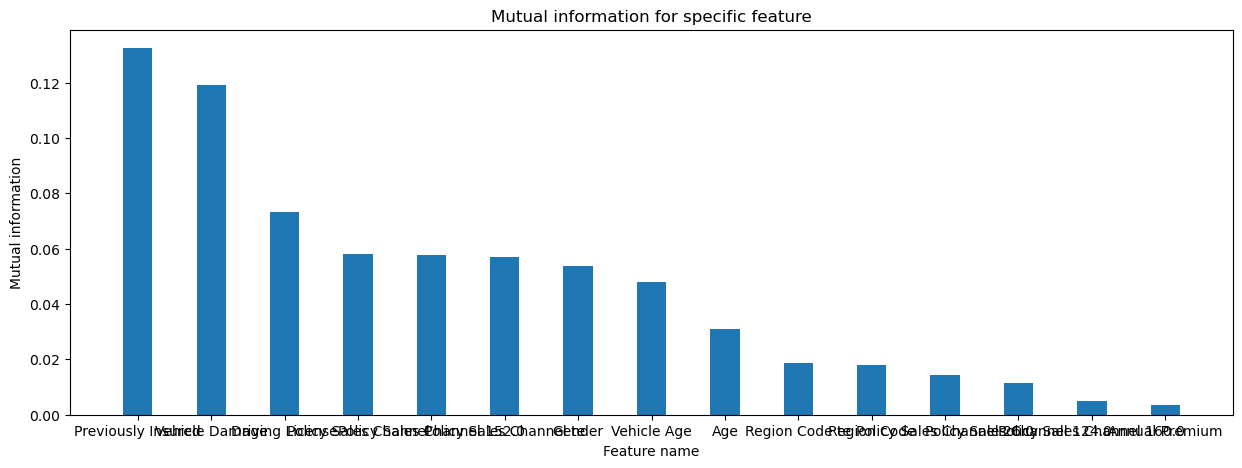

In [8]:
mi = mutual_info_classif(X_dropped, y, random_state=42)

data = pd.Series(mi, name="MI Scores", index=X_dropped.columns).sort_values(ascending=False)
region_code = list(map(underscore_to_space, data.index.tolist()))
customers = list(data.values.tolist())

fig = plt.figure(figsize = (15, 5))
plt.bar(region_code[:15], customers[:15],
        width = 0.4)
 
plt.xlabel("Feature name")
plt.ylabel("Mutual information")
plt.title("Mutual information for specific feature")
plt.show()

### 17.1 Feature importances

Trained model gives us some statistics about features. I will print them using "plot_importance" function:

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

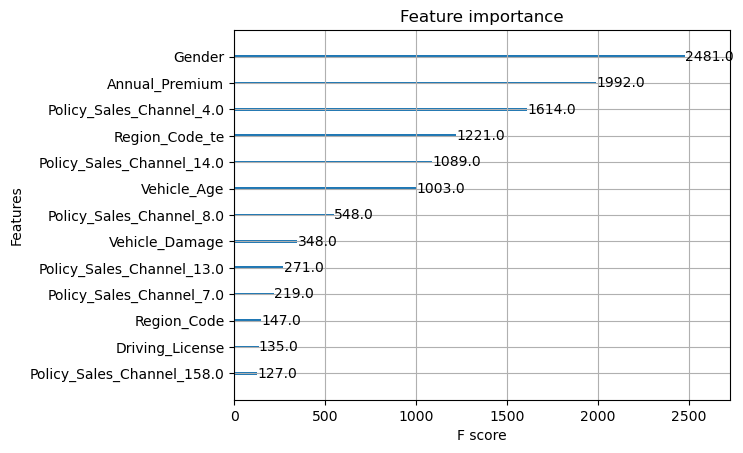

In [14]:
xgb_loaded = xgboost.Booster()
xgb_loaded.load_model("xgb-model4.json")
xgb_loaded.feature_names = X_dropped.columns.values.tolist()
plot_importance(xgb_loaded, height=0.1, max_num_features=13)

The conclusions are not identical, but we can see similarities. In three most important Policy_Sales_Channel One Hot Encoding columns there are number 124 and 26. Original, non-transformed columns have very high score, but their order is different.

### 17.2 Permutation importance

In [15]:
perm = PermutationImportance(model, random_state=42, cv='prefit').fit(X_dropped, y)
eli5.show_weights(perm, feature_names = X_dropped.columns.values)

Weight,Feature
0.0050 ± 0.0004,Vehicle_Age
0.0007 ± 0.0001,Age
0.0004 ± 0.0001,Annual_Premium
0.0004 ± 0.0001,Policy_Sales_Channel
0.0003 ± 0.0001,Vehicle_Damage
0.0002 ± 0.0000,Policy_Sales_Channel_te
0.0002 ± 0.0001,Previously_Insured
0.0002 ± 0.0001,Region_Code
0.0001 ± 0.0001,Region_Code_te
0.0001 ± 0.0001,Policy_Sales_Channel_26.0


### 17.3 Partial Dependence Plot

A partial dependence plot shows how the specific value of a given feature affects prediction on average. It is much easier to explain this concept with an example:

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

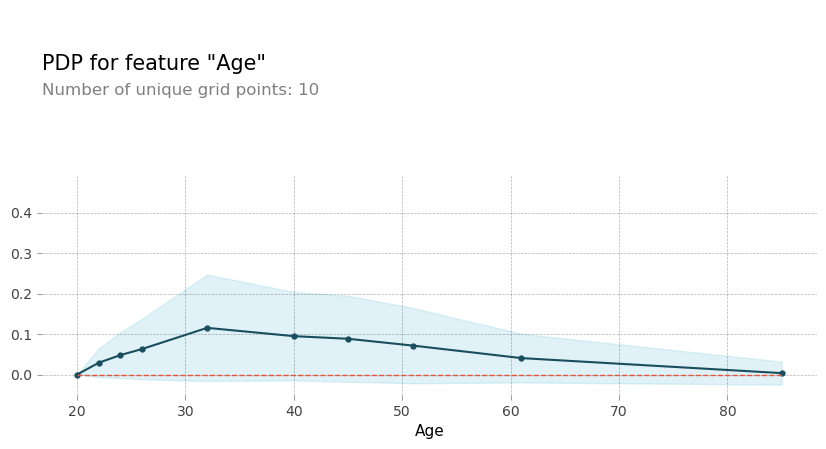

In [18]:
# TODO: do something with these ugly logs

feature_names = X_dropped.columns.values.tolist()
selected_feature = 'Age'
pdp_isolated = pdp.pdp_isolate(model=model, dataset=X_dropped, model_features=feature_names, feature=selected_feature)
pdp.pdp_plot(pdp_isolated, selected_feature, figsize=(10, 5))
plt.show()

The impact of the "Age" feature is strong. It adds more than 0.1 point to the predicted target around the age of 32–33, and the gain slowly falls on the left and right sides of the plot (younger and older people, respectively). There are few other relationship worth noting:

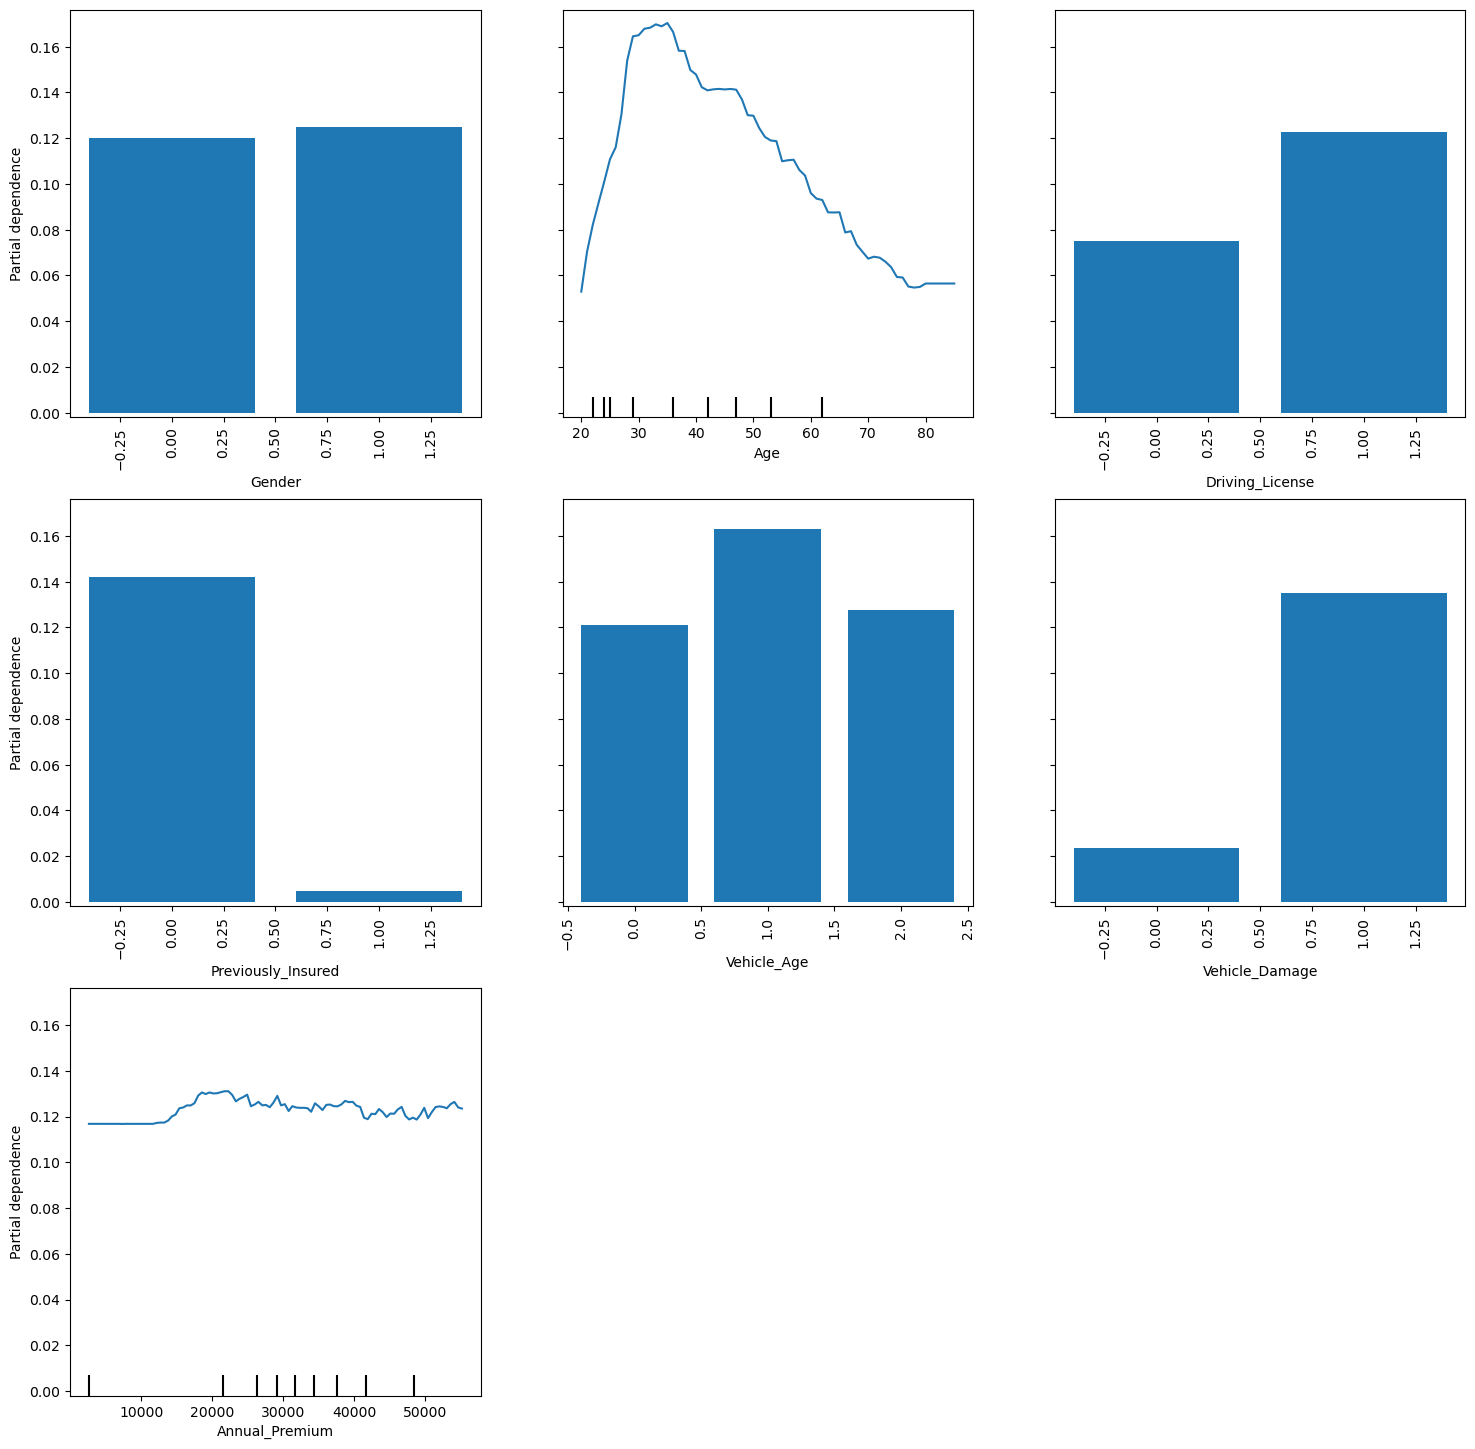

In [17]:
gender_idx = X_dropped.columns.values.tolist().index("Gender")
age_idx = X_dropped.columns.values.tolist().index("Age")
dl_idx = X_dropped.columns.values.tolist().index("Driving_License")
pi_idx = X_dropped.columns.values.tolist().index("Previously_Insured")
vage_idx = X_dropped.columns.values.tolist().index("Vehicle_Age")
damage_idx = X_dropped.columns.values.tolist().index("Vehicle_Damage")
premium_idx = X_dropped.columns.values.tolist().index("Annual_Premium")
features = [gender_idx, age_idx, dl_idx, pi_idx, vage_idx, damage_idx, premium_idx]
categorical = ["Gender", "Driving_License", "Previously_Insured", "Vehicle_Age", "Vehicle_Damage"]

_, ax = plt.subplots(figsize=(18, 18))
PartialDependenceDisplay.from_estimator(model, X_dropped, features, categorical_features=categorical, n_jobs=-1, ax=ax)
plt.show()

People already insured (1.0) are less likely to buy new insurance, but owners of damaged vehicles are more willing to do so. Men are minimally more likely to use the service. The cheapest insurance policies are the least frequently chosen.

What's interesting?
***These conclusions are very similar to the ones from KDE plots!*** XGB is much more complex and can use much more sophisticated relationships, but our initial observations are reflected.

Still, individual observations vary. Using KDE plots, one can conclude that owners of young (<1 year) cars (Vehicle_Age=1) usually don't want to insure their vehicles, but the partial dependence plot indicates that their score is higher than for the older ones.

## 18. Summary
TODO: write paragraph from these points:
1. Model use similar things to initial data analysis
2. Significance of specific steps based on the chart
3. An attempt to simplify the model (maybe standard LGBM/XGB + drop Vintage + Target Encoding on Policy_Sales_Channel and Region_Code + fast scaler?)

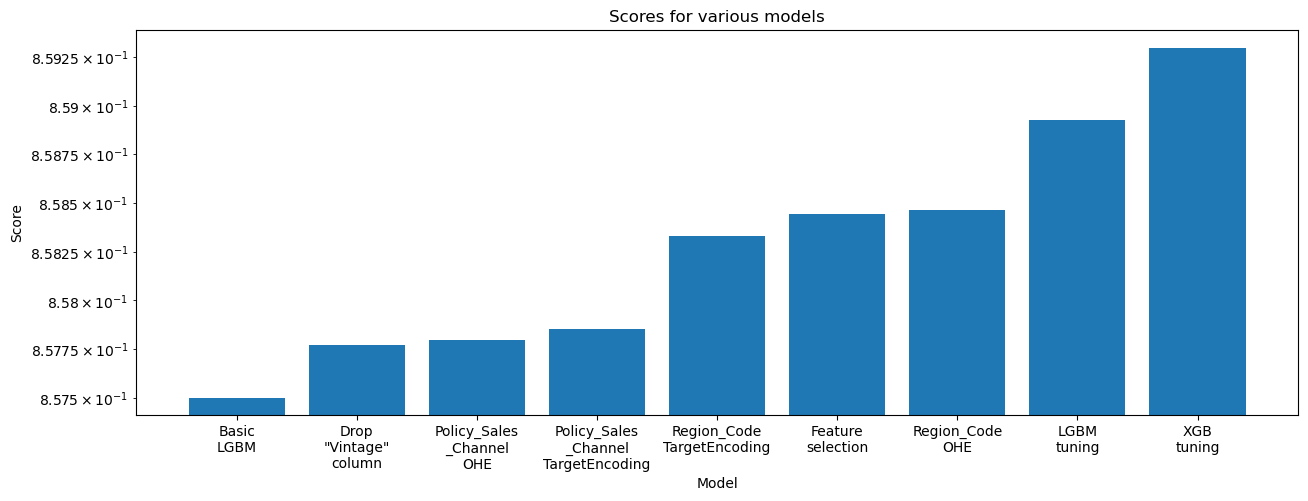

In [2]:
# TODO: calculate again

scores = [basic_lgbm_score, drop_vintage_score, psc_ohe_score, psc_te_score, rc_te_score, feature_selection_score, rc_ohe_score, lgbm_tuning, xgb_tuning]
scores_names = ['Basic\nLGBM', 'Drop\n"Vintage"\ncolumn', 'Policy_Sales\n_Channel\nOHE', 'Policy_Sales\n_Channel\nTargetEncoding', 'Region_Code\nTargetEncoding', 'Feature\nselection', 'Region_Code\nOHE', 'LGBM\ntuning', 'XGB\ntuning']

fig = plt.figure(figsize = (15, 5))
plt.bar(scores_names, scores)
 
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Scores for various models")
plt.yscale("log")
plt.show()